<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/AutoGluonForecast_1_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autogluon

In [ ]:
!pip install --upgrade mxnet

In [ ]:
#designed for Jupyter/kaggle/colab
import pandas as pd
import numpy as np
#import matplotlib for plotting 
import matplotlib.pyplot as plt
%matplotlib inline
#import normalization
from sklearn import preprocessing

#autogluon
from autogluon.tabular import TabularDataset, TabularPredictor  

In [ ]:
#metatrader5 file format
df=pd.read_csv('/content/EURUSD_M5_201501020900_202202140140.csv')

In [ ]:
print(df.head())
print(df.tail())
df.info()

  <DATE>\t<TIME>\t<OPEN>\t<HIGH>\t<LOW>\t<CLOSE>\t<TICKVOL>\t<VOL>\t<SPREAD>
0  2015.01.02\t09:00:00\t1.20538\t1.20541\t1.2034...                        
1  2015.01.02\t09:05:00\t1.20415\t1.20450\t1.2035...                        
2  2015.01.02\t09:10:00\t1.20383\t1.20439\t1.2038...                        
3  2015.01.02\t09:15:00\t1.20409\t1.20462\t1.2040...                        
4  2015.01.02\t09:20:00\t1.20429\t1.20479\t1.2040...                        
       <DATE>\t<TIME>\t<OPEN>\t<HIGH>\t<LOW>\t<CLOSE>\t<TICKVOL>\t<VOL>\t<SPREAD>
529960  2022.02.14\t01:20:00\t1.13532\t1.13588\t1.1353...                        
529961  2022.02.14\t01:25:00\t1.13566\t1.13594\t1.1355...                        
529962  2022.02.14\t01:30:00\t1.13593\t1.13611\t1.1357...                        
529963  2022.02.14\t01:35:00\t1.13610\t1.13610\t1.1358...                        
529964  2022.02.14\t01:40:00\t1.13607\t1.13607\t1.1359...                        
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [ ]:
df.columns=['header']


In [ ]:
df = df.header.str.split('\t', expand=True)


In [ ]:
df

,0,1,2,3,4,5,6,7,8
0,2015.01.02,09:00:00,1.20538,1.20541,1.20344,1.20416,475,0,11
1,2015.01.02,09:05:00,1.20415,1.20450,1.20356,1.20386,404,0,12
2,2015.01.02,09:10:00,1.20383,1.20439,1.20380,1.20410,357,0,13
3,2015.01.02,09:15:00,1.20409,1.20462,1.20408,1.20431,247,0,12
4,2015.01.02,09:20:00,1.20429,1.20479,1.20409,1.20468,220,0,12
...,...,...,...,...,...,...,...,...,...
529960,2022.02.14,01:20:00,1.13532,1.13588,1.13531,1.13567,261,0,7
529961,2022.02.14,01:25:00,1.13566,1.13594,1.13554,1.13593,145,0,7
529962,2022.02.14,01:30:00,1.13593,1.13611,1.13572,1.13610,94,0,6
529963,2022.02.14,01:35:00,1.13610,1.13610,1.13583,1.13607,59,0,10


In [ ]:
#choose range of data for backtesting
df['date_time'] = df[0] + ' ' + df[1]
pd.to_datetime(df.date_time)
df.set_index('date_time',inplace=True)
df.drop(columns=[0,1], inplace=True)
df

,2,3,4,5,6,7,8
date_time,,,,,,,
2015.01.02 09:00:00,1.20538,1.20541,1.20344,1.20416,475,0,11
2015.01.02 09:05:00,1.20415,1.20450,1.20356,1.20386,404,0,12
2015.01.02 09:10:00,1.20383,1.20439,1.20380,1.20410,357,0,13
2015.01.02 09:15:00,1.20409,1.20462,1.20408,1.20431,247,0,12
2015.01.02 09:20:00,1.20429,1.20479,1.20409,1.20468,220,0,12
...,...,...,...,...,...,...,...
2022.02.14 01:20:00,1.13532,1.13588,1.13531,1.13567,261,0,7
2022.02.14 01:25:00,1.13566,1.13594,1.13554,1.13593,145,0,7
2022.02.14 01:30:00,1.13593,1.13611,1.13572,1.13610,94,0,6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 529965 entries, 2015.01.02 09:00:00 to 2022.02.14 01:40:00
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   2       529965 non-null  object
 1   3       529965 non-null  object
 2   4       529965 non-null  object
 3   5       529965 non-null  object
 4   6       529965 non-null  object
 5   7       529965 non-null  object
 6   8       529965 non-null  object
dtypes: object(7)
memory usage: 32.3+ MB


In [ ]:
#Choose if you want tail or date_time range here for backtest
#df_close_col = pd.DataFrame(data=df.iloc[:,5].tail(350000))
df_backtest = pd.DataFrame(df.loc['2015.12.15 01:00:00':'2022.01.31 01:40:00',5])

In [ ]:
df_backtest

,5
date_time,
2015.12.15 01:00:00,1.09972
2015.12.15 01:05:00,1.09999
2015.12.15 01:10:00,1.09978
2015.12.15 01:15:00,1.09957
2015.12.15 01:20:00,1.09970
...,...
2022.01.31 01:20:00,1.11455
2022.01.31 01:25:00,1.11455
2022.01.31 01:30:00,1.11463


In [ ]:
#use df_backtest later on df_train
#separate variables
df_close_col = df_backtest

In [ ]:
#separate variables
df_backtest_idx = df_backtest
#return index to int
df_backtest_idx.reset_index(level=['date_time'], inplace=True)
df_backtest_idx = df_backtest_idx.iloc[-1440:]
df_backtest_idx

,date_time,5
454707,2022.01.24 01:40:00,1.13399
454708,2022.01.24 01:45:00,1.13402
454709,2022.01.24 01:50:00,1.13417
454710,2022.01.24 01:55:00,1.13408
454711,2022.01.24 02:00:00,1.13369
...,...,...
456142,2022.01.31 01:20:00,1.11455
456143,2022.01.31 01:25:00,1.11455
456144,2022.01.31 01:30:00,1.11463
456145,2022.01.31 01:35:00,1.11486


In [ ]:
df_backtest_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 454707 to 456146
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_time  1440 non-null   object
 1   5          1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


In [ ]:
df_close_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456147 entries, 0 to 456146
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date_time  456147 non-null  object
 1   5          456147 non-null  object
dtypes: object(2)
memory usage: 7.0+ MB


In [ ]:
df_close_col[5] = df_close_col[5].astype(float, errors = 'raise')

In [ ]:
df_close_col.drop(['date_time'], axis=1,inplace=True)

In [ ]:
df_close_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456147 entries, 0 to 456146
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   5       456147 non-null  float64
dtypes: float64(1)
memory usage: 3.5 MB


In [ ]:
df_close_col.isnull().sum()  

5    0
dtype: int64

In [ ]:
df_close_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456147 entries, 0 to 456146
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   5       456147 non-null  float64
dtypes: float64(1)
memory usage: 3.5 MB


In [ ]:
###working here###

In [ ]:
###df441 to df 480###
df480 = pd.DataFrame(data=df_close_col.iloc[-347040:-345600])
df480['row_num']=np.arange(len(df480))
df480.set_index('row_num',inplace=True)
df480 = df480.rename(columns={5:'frame_480'})
print(df480)

df479 = pd.DataFrame(data=df_close_col.iloc[-345600:-344160])
df479['row_num']=np.arange(len(df479))
df479.set_index('row_num',inplace=True)
df479 = df479.rename(columns={5:'frame_479'})
print(df479)

df478 = pd.DataFrame(data=df_close_col.iloc[-344160:-342720])
df478['row_num']=np.arange(len(df478))
df478.set_index('row_num',inplace=True)
df478 = df478.rename(columns={5:'frame_478'})
print(478)

df477 = pd.DataFrame(data=df_close_col.iloc[-342720:-341280])
df477['row_num']=np.arange(len(df477))
df477.set_index('row_num',inplace=True)
df477 = df477.rename(columns={5:'frame_477'})
print(df477)

df476 = pd.DataFrame(data=df_close_col.iloc[-341280:-339840])
df476['row_num']=np.arange(len(df476))
df476.set_index('row_num',inplace=True)
df476 = df476.rename(columns={5:'frame_476'})
print(df476)

df475 = pd.DataFrame(data=df_close_col.iloc[-339840:-338400])
df475['row_num']=np.arange(len(df475))
df475.set_index('row_num',inplace=True)
df475 = df475.rename(columns={5:'frame_475'})
print(df475)

df474 = pd.DataFrame(data=df_close_col.iloc[-338400:-336960])
df474['row_num']=np.arange(len(df474))
df474.set_index('row_num',inplace=True)
df474 = df474.rename(columns={5:'frame_474'})
print(df474)

df473 = pd.DataFrame(data=df_close_col.iloc[-336960:-335520])
df473['row_num']=np.arange(len(df473))
df473.set_index('row_num',inplace=True)
df473 = df473.rename(columns={5:'frame_473'})
print(df473)

df472 = pd.DataFrame(data=df_close_col.iloc[-335520:-334080])
df472['row_num']=np.arange(len(df472))
df472.set_index('row_num',inplace=True)
df472 = df472.rename(columns={5:'frame_472'})
print(df472)

df471 = pd.DataFrame(data=df_close_col.iloc[-334080:-332640])
df471['row_num']=np.arange(len(df471))
df471.set_index('row_num',inplace=True)
df471 = df471.rename(columns={5:'frame_471'})
print(df471)

df470 = pd.DataFrame(data=df_close_col.iloc[-332640:-331200])
df470['row_num']=np.arange(len(df470))
df470.set_index('row_num',inplace=True)
df470 = df470.rename(columns={5:'frame_470'})
print(df470)

df469 = pd.DataFrame(data=df_close_col.iloc[-331200:-329760])
df469['row_num']=np.arange(len(df469))
df469.set_index('row_num',inplace=True)
df469 = df469.rename(columns={5:'frame_469'})
print(df469)

df468 = pd.DataFrame(data=df_close_col.iloc[-329760:-328320])
df468['row_num']=np.arange(len(df468))
df468.set_index('row_num',inplace=True)
df468 = df468.rename(columns={5:'frame_468'})
print(df468)

df227 = pd.DataFrame(data=df_close_col.iloc[-328320:-326880])
df227['row_num']=np.arange(len(df227))
df227.set_index('row_num',inplace=True)
df227 = df227.rename(columns={5:'frame_227'})
print(df227)

df226 = pd.DataFrame(data=df_close_col.iloc[-326880:-325440])
df226['row_num']=np.arange(len(df226))
df226.set_index('row_num',inplace=True)
df226 = df226.rename(columns={5:'frame_226'})
print(df226)

df225 = pd.DataFrame(data=df_close_col.iloc[-325440:-324000])
df225['row_num']=np.arange(len(df225))
df225.set_index('row_num',inplace=True)
df225 = df225.rename(columns={5:'frame_225'})
print(df225)

df224 = pd.DataFrame(data=df_close_col.iloc[-324000:-322560])
df224['row_num']=np.arange(len(df224))
df224.set_index('row_num',inplace=True)
df224 = df224.rename(columns={5:'frame_224'})
print(df224)

df223 = pd.DataFrame(data=df_close_col.iloc[-322560:-321120])
df223['row_num']=np.arange(len(df223))
df223.set_index('row_num',inplace=True)
df223 = df223.rename(columns={5:'frame_223'})
print(df223)

df222 = pd.DataFrame(data=df_close_col.iloc[-321120:-319680])
df222['row_num']=np.arange(len(df222))
df222.set_index('row_num',inplace=True)
df222 = df222.rename(columns={5:'frame_222'})
print(df222)

df221 = pd.DataFrame(data=df_close_col.iloc[-319680:-318240])
df221['row_num']=np.arange(len(df221))
df221.set_index('row_num',inplace=True)
df221 = df221.rename(columns={5:'frame_221'})
print(df221)


df220 = pd.DataFrame(data=df_close_col.iloc[-318240:-316800])
df220['row_num']=np.arange(len(df220))
df220.set_index('row_num',inplace=True)
df220 = df220.rename(columns={5:'frame_220'})
print(df220)

df219 = pd.DataFrame(data=df_close_col.iloc[-316800:-315360])
df219['row_num']=np.arange(len(df219))
df219.set_index('row_num',inplace=True)
df219 = df219.rename(columns={5:'frame_219'})
print(df219)

df218 = pd.DataFrame(data=df_close_col.iloc[-315360:-313920])
df218['row_num']=np.arange(len(df218))
df218.set_index('row_num',inplace=True)
df218 = df218.rename(columns={5:'frame_218'})
print(df218)

df217 = pd.DataFrame(data=df_close_col.iloc[-313920:-312480])
df217['row_num']=np.arange(len(df217))
df217.set_index('row_num',inplace=True)
df217 = df217.rename(columns={5:'frame_217'})
print(df217)

df216 = pd.DataFrame(data=df_close_col.iloc[-312480:-311040])
df216['row_num']=np.arange(len(df216))
df216.set_index('row_num',inplace=True)
df216 = df216.rename(columns={5:'frame_216'})
print(df216)

df215 = pd.DataFrame(data=df_close_col.iloc[-311040:-309600])
df215['row_num']=np.arange(len(df215))
df215.set_index('row_num',inplace=True)
df215 = df215.rename(columns={5:'frame_215'})
print(df215)

df214 = pd.DataFrame(data=df_close_col.iloc[-309600:-308160])
df214['row_num']=np.arange(len(df214))
df214.set_index('row_num',inplace=True)
df214 = df214.rename(columns={5:'frame_214'})
print(df214)

df213 = pd.DataFrame(data=df_close_col.iloc[-308160:-306720])
df213['row_num']=np.arange(len(df213))
df213.set_index('row_num',inplace=True)
df213 = df213.rename(columns={5:'frame_213'})
print(df213)

df212 = pd.DataFrame(data=df_close_col.iloc[-306720:-305280])
df212['row_num']=np.arange(len(df212))
df212.set_index('row_num',inplace=True)
df212 = df212.rename(columns={5:'frame_212'})
print(df212)

df211 = pd.DataFrame(data=df_close_col.iloc[-305280:-303840])
df211['row_num']=np.arange(len(df211))
df211.set_index('row_num',inplace=True)
df211 = df211.rename(columns={5:'frame_211'})
print(df211)

df210 = pd.DataFrame(data=df_close_col.iloc[-303840:-302400])
df210['row_num']=np.arange(len(df210))
df210.set_index('row_num',inplace=True)
df210 = df210.rename(columns={5:'frame_210'})
print(df210)

df209 = pd.DataFrame(data=df_close_col.iloc[-302400:-300960])
df209['row_num']=np.arange(len(df209))
df209.set_index('row_num',inplace=True)
df209 = df209.rename(columns={5:'frame_209'})
print(df209)

df208 = pd.DataFrame(data=df_close_col.iloc[-300960:-299520])
df208['row_num']=np.arange(len(df208))
df208.set_index('row_num',inplace=True)
df208 = df208.rename(columns={5:'frame_208'})
print(df208)

df207 = pd.DataFrame(data=df_close_col.iloc[-299520:-298080])
df207['row_num']=np.arange(len(df207))
df207.set_index('row_num',inplace=True)
df207 = df207.rename(columns={5:'frame_207'})
print(df207)

df206 = pd.DataFrame(data=df_close_col.iloc[-298080:-296640])
df206['row_num']=np.arange(len(df206))
df206.set_index('row_num',inplace=True)
df206 = df206.rename(columns={5:'frame_206'})
print(df206)

df205 = pd.DataFrame(data=df_close_col.iloc[-296640:-295200])
df205['row_num']=np.arange(len(df205))
df205.set_index('row_num',inplace=True)
df205 = df205.rename(columns={5:'frame_205'})
print(df205)

df204 = pd.DataFrame(data=df_close_col.iloc[-295200:-293760])
df204['row_num']=np.arange(len(df204))
df204.set_index('row_num',inplace=True)
df204 = df204.rename(columns={5:'frame_204'})
print(df204)

df203 = pd.DataFrame(data=df_close_col.iloc[-293760:-292320])
df203['row_num']=np.arange(len(df203))
df203.set_index('row_num',inplace=True)
df203 = df203.rename(columns={5:'frame_203'})
print(df203)

df202 = pd.DataFrame(data=df_close_col.iloc[-292320:-290880])
df202['row_num']=np.arange(len(df202))
df202.set_index('row_num',inplace=True)
df202 = df202.rename(columns={5:'frame_202'})
print(df202)

df201 = pd.DataFrame(data=df_close_col.iloc[-290880:-289440])
df201['row_num']=np.arange(len(df201))
df201.set_index('row_num',inplace=True)
df201 = df201.rename(columns={5:'frame_201'})
print(df201)
###df441 to df 480###

         frame_240
row_num           
0          1.12410
1          1.12425
2          1.12427
3          1.12427
4          1.12420
...            ...
1435       1.12588
1436       1.12568
1437       1.12602
1438       1.12595
1439       1.12601

[1440 rows x 1 columns]
         frame_239
row_num           
0          1.12583
1          1.12594
2          1.12595
3          1.12609
4          1.12600
...            ...
1435       1.12165
1436       1.12151
1437       1.12151
1438       1.12161
1439       1.12138

[1440 rows x 1 columns]
         frame_238
row_num           
0          1.12132
1          1.12109
2          1.12071
3          1.12110
4          1.12115
...            ...
1435       1.11669
1436       1.11671
1437       1.11663
1438       1.11664
1439       1.11666

[1440 rows x 1 columns]
         frame_237
row_num           
0          1.11661
1          1.11653
2          1.11653
3          1.11666
4          1.11663
...            ...
1435       1.13766
1436       1.

In [ ]:
###df401 to df440###
df200 = pd.DataFrame(data=df_close_col.iloc[-289440:-288000])
df200['row_num']=np.arange(len(df200))
df200.set_index('row_num',inplace=True)
df200 = df200.rename(columns={5:'frame_200'})
print(df200)

df199 = pd.DataFrame(data=df_close_col.iloc[-288000:-286560])
df199['row_num']=np.arange(len(df199))
df199.set_index('row_num',inplace=True)
df199 = df199.rename(columns={5:'frame_199'})
print(df199)

df198 = pd.DataFrame(data=df_close_col.iloc[-286560:-285120])
df198['row_num']=np.arange(len(df198))
df198.set_index('row_num',inplace=True)
df198 = df198.rename(columns={5:'frame_198'})
print(df198)

df197 = pd.DataFrame(data=df_close_col.iloc[-285120:-283680])
df197['row_num']=np.arange(len(df197))
df197.set_index('row_num',inplace=True)
df197 = df197.rename(columns={5:'frame_197'})
print(df197)

df196 = pd.DataFrame(data=df_close_col.iloc[-283680:-282240])
df196['row_num']=np.arange(len(df196))
df196.set_index('row_num',inplace=True)
df196 = df196.rename(columns={5:'frame_196'})
print(df196)

df195 = pd.DataFrame(data=df_close_col.iloc[-282240:-280800])
df195['row_num']=np.arange(len(df195))
df195.set_index('row_num',inplace=True)
df195 = df195.rename(columns={5:'frame_195'})
print(df195)

df194 = pd.DataFrame(data=df_close_col.iloc[-280800:-279360])
df194['row_num']=np.arange(len(df194))
df194.set_index('row_num',inplace=True)
df194 = df194.rename(columns={5:'frame_194'})
print(df194)

df193 = pd.DataFrame(data=df_close_col.iloc[-279360:-277920])
df193['row_num']=np.arange(len(df193))
df193.set_index('row_num',inplace=True)
df193 = df193.rename(columns={5:'frame_193'})
print(df193)

df192 = pd.DataFrame(data=df_close_col.iloc[-277920:-276480])
df192['row_num']=np.arange(len(df192))
df192.set_index('row_num',inplace=True)
df192 = df192.rename(columns={5:'frame_192'})
print(df192)

df191 = pd.DataFrame(data=df_close_col.iloc[-276480:-275040])
df191['row_num']=np.arange(len(df191))
df191.set_index('row_num',inplace=True)
df191 = df191.rename(columns={5:'frame_191'})
print(df191)

df190 = pd.DataFrame(data=df_close_col.iloc[-275040:-273600])
df190['row_num']=np.arange(len(df190))
df190.set_index('row_num',inplace=True)
df190 = df190.rename(columns={5:'frame_190'})
print(df190)

df189 = pd.DataFrame(data=df_close_col.iloc[-273600:-272160])
df189['row_num']=np.arange(len(df189))
df189.set_index('row_num',inplace=True)
df189 = df189.rename(columns={5:'frame_189'})
print(df189)

df188 = pd.DataFrame(data=df_close_col.iloc[-272160:-270720])
df188['row_num']=np.arange(len(df188))
df188.set_index('row_num',inplace=True)
df188 = df188.rename(columns={5:'frame_188'})
print(df188)

df187 = pd.DataFrame(data=df_close_col.iloc[-270720:-269280])
df187['row_num']=np.arange(len(df187))
df187.set_index('row_num',inplace=True)
df187 = df187.rename(columns={5:'frame_187'})
print(df187)

df186 = pd.DataFrame(data=df_close_col.iloc[-269280:-267840])
df186['row_num']=np.arange(len(df186))
df186.set_index('row_num',inplace=True)
df186 = df186.rename(columns={5:'frame_186'})
print(df186)

df185 = pd.DataFrame(data=df_close_col.iloc[-267840:-266400])
df185['row_num']=np.arange(len(df185))
df185.set_index('row_num',inplace=True)
df185 = df185.rename(columns={5:'frame_185'})
print(df185)

df184 = pd.DataFrame(data=df_close_col.iloc[-266400:-264960])
df184['row_num']=np.arange(len(df184))
df184.set_index('row_num',inplace=True)
df184 = df184.rename(columns={5:'frame_184'})
print(df184)

df183 = pd.DataFrame(data=df_close_col.iloc[-264960:-263520])
df183['row_num']=np.arange(len(df183))
df183.set_index('row_num',inplace=True)
df183 = df183.rename(columns={5:'frame_183'})
print(df183)

df182 = pd.DataFrame(data=df_close_col.iloc[-263520:-262080])
df182['row_num']=np.arange(len(df182))
df182.set_index('row_num',inplace=True)
df182 = df182.rename(columns={5:'frame_182'})
print(df182)

df181 = pd.DataFrame(data=df_close_col.iloc[-262080:-260640])
df181['row_num']=np.arange(len(df181))
df181.set_index('row_num',inplace=True)
df181 = df181.rename(columns={5:'frame_181'})
print(df181)


df180 = pd.DataFrame(data=df_close_col.iloc[-260640:-259200])
df180['row_num']=np.arange(len(df180))
df180.set_index('row_num',inplace=True)
df180 = df180.rename(columns={5:'frame_180'})
print(df180)

df179 = pd.DataFrame(data=df_close_col.iloc[-259200:-257760])
df179['row_num']=np.arange(len(df179))
df179.set_index('row_num',inplace=True)
df179 = df179.rename(columns={5:'frame_179'})
print(df179)

df178 = pd.DataFrame(data=df_close_col.iloc[-257760:-256320])
df178['row_num']=np.arange(len(df178))
df178.set_index('row_num',inplace=True)
df178 = df178.rename(columns={5:'frame_178'})
print(df178)

df177 = pd.DataFrame(data=df_close_col.iloc[-256320:-254880])
df177['row_num']=np.arange(len(df177))
df177.set_index('row_num',inplace=True)
df177 = df177.rename(columns={5:'frame_177'})
print(df177)

df176 = pd.DataFrame(data=df_close_col.iloc[-254880:-253440])
df176['row_num']=np.arange(len(df176))
df176.set_index('row_num',inplace=True)
df176 = df176.rename(columns={5:'frame_176'})
print(df176)

df175 = pd.DataFrame(data=df_close_col.iloc[-253440:-252000])
df175['row_num']=np.arange(len(df175))
df175.set_index('row_num',inplace=True)
df175 = df175.rename(columns={5:'frame_175'})
print(df175)

df174 = pd.DataFrame(data=df_close_col.iloc[-252000:-250560])
df174['row_num']=np.arange(len(df174))
df174.set_index('row_num',inplace=True)
df174 = df174.rename(columns={5:'frame_174'})
print(df174)

df173 = pd.DataFrame(data=df_close_col.iloc[-250560:-249120])
df173['row_num']=np.arange(len(df173))
df173.set_index('row_num',inplace=True)
df173 = df173.rename(columns={5:'frame_173'})
print(df173)

df172 = pd.DataFrame(data=df_close_col.iloc[-249120:-247680])
df172['row_num']=np.arange(len(df172))
df172.set_index('row_num',inplace=True)
df172 = df172.rename(columns={5:'frame_172'})
print(df172)

df171 = pd.DataFrame(data=df_close_col.iloc[-247680:-246240])
df171['row_num']=np.arange(len(df171))
df171.set_index('row_num',inplace=True)
df171 = df171.rename(columns={5:'frame_171'})
print(df171)

df170 = pd.DataFrame(data=df_close_col.iloc[-246240:-244800])
df170['row_num']=np.arange(len(df170))
df170.set_index('row_num',inplace=True)
df170 = df170.rename(columns={5:'frame_170'})
print(df170)

df169 = pd.DataFrame(data=df_close_col.iloc[-244800:-243360])
df169['row_num']=np.arange(len(df169))
df169.set_index('row_num',inplace=True)
df169 = df169.rename(columns={5:'frame_169'})
print(df169)

df168 = pd.DataFrame(data=df_close_col.iloc[-243360:-241920])
df168['row_num']=np.arange(len(df168))
df168.set_index('row_num',inplace=True)
df168 = df168.rename(columns={5:'frame_168'})
print(df168)

df167 = pd.DataFrame(data=df_close_col.iloc[-241920:-240480])
df167['row_num']=np.arange(len(df167))
df167.set_index('row_num',inplace=True)
df167 = df167.rename(columns={5:'frame_167'})
print(df167)

df166 = pd.DataFrame(data=df_close_col.iloc[-240480:-239040])
df166['row_num']=np.arange(len(df166))
df166.set_index('row_num',inplace=True)
df166 = df166.rename(columns={5:'frame_166'})
print(df166)

df165 = pd.DataFrame(data=df_close_col.iloc[-239040:-237600])
df165['row_num']=np.arange(len(df165))
df165.set_index('row_num',inplace=True)
df165 = df165.rename(columns={5:'frame_165'})
print(df165)

df164 = pd.DataFrame(data=df_close_col.iloc[-237600:-236160])
df164['row_num']=np.arange(len(df164))
df164.set_index('row_num',inplace=True)
df164 = df164.rename(columns={5:'frame_164'})
print(df164)

df163 = pd.DataFrame(data=df_close_col.iloc[-236160:-234720])
df163['row_num']=np.arange(len(df163))
df163.set_index('row_num',inplace=True)
df163 = df163.rename(columns={5:'frame_163'})
print(df163)

df162 = pd.DataFrame(data=df_close_col.iloc[-234720:-233280])
df162['row_num']=np.arange(len(df162))
df162.set_index('row_num',inplace=True)
df162 = df162.rename(columns={5:'frame_162'})
print(df162)

df161 = pd.DataFrame(data=df_close_col.iloc[-233280:-231840])
df161['row_num']=np.arange(len(df161))
df161.set_index('row_num',inplace=True)
df161 = df161.rename(columns={5:'frame_161'})
print(df161)
###df401 to df440###

         frame_200
row_num           
0          1.23376
1          1.23382
2          1.23377
3          1.23385
4          1.23396
...            ...
1435       1.23384
1436       1.23404
1437       1.23398
1438       1.23373
1439       1.23397

[1440 rows x 1 columns]
         frame_199
row_num           
0          1.23413
1          1.23397
2          1.23432
3          1.23410
4          1.23415
...            ...
1435       1.24516
1436       1.24506
1437       1.24507
1438       1.24502
1439       1.24515

[1440 rows x 1 columns]
         frame_198
row_num           
0          1.24514
1          1.24491
2          1.24495
3          1.24495
4          1.24500
...            ...
1435       1.22972
1436       1.22993
1437       1.23004
1438       1.23000
1439       1.22994

[1440 rows x 1 columns]
         frame_197
row_num           
0          1.23019
1          1.23010
2          1.23022
3          1.23033
4          1.23034
...            ...
1435       1.23276
1436       1.

In [ ]:
###df361 to df400###
df160 = pd.DataFrame(data=df_close_col.iloc[-231840:-230400])
df160['row_num']=np.arange(len(df160))
df160.set_index('row_num',inplace=True)
df160 = df160.rename(columns={5:'frame_160'})
print(df160)

df159 = pd.DataFrame(data=df_close_col.iloc[-230400:-228960])
df159['row_num']=np.arange(len(df159))
df159.set_index('row_num',inplace=True)
df159 = df159.rename(columns={5:'frame_159'})
print(df159)

df158 = pd.DataFrame(data=df_close_col.iloc[-228960:-227520])
df158['row_num']=np.arange(len(df158))
df158.set_index('row_num',inplace=True)
df158 = df158.rename(columns={5:'frame_158'})
print(df158)

df157 = pd.DataFrame(data=df_close_col.iloc[-227520:-226080])
df157['row_num']=np.arange(len(df157))
df157.set_index('row_num',inplace=True)
df157 = df157.rename(columns={5:'frame_157'})
print(df157)

df156 = pd.DataFrame(data=df_close_col.iloc[-226080:-224640])
df156['row_num']=np.arange(len(df156))
df156.set_index('row_num',inplace=True)
df156 = df156.rename(columns={5:'frame_156'})
print(df156)

df155 = pd.DataFrame(data=df_close_col.iloc[-224640:-223200])
df155['row_num']=np.arange(len(df155))
df155.set_index('row_num',inplace=True)
df155 = df155.rename(columns={5:'frame_155'})
print(df155)

df154 = pd.DataFrame(data=df_close_col.iloc[-223200:-221760])
df154['row_num']=np.arange(len(df154))
df154.set_index('row_num',inplace=True)
df154 = df154.rename(columns={5:'frame_154'})
print(df154)

df153 = pd.DataFrame(data=df_close_col.iloc[-221760:-220320])
df153['row_num']=np.arange(len(df153))
df153.set_index('row_num',inplace=True)
df153 = df153.rename(columns={5:'frame_153'})
print(df153)

df152 = pd.DataFrame(data=df_close_col.iloc[-220320:-218880])
df152['row_num']=np.arange(len(df152))
df152.set_index('row_num',inplace=True)
df152 = df152.rename(columns={5:'frame_152'})
print(df152)

df151 = pd.DataFrame(data=df_close_col.iloc[-218880:-217440])
df151['row_num']=np.arange(len(df151))
df151.set_index('row_num',inplace=True)
df151 = df151.rename(columns={5:'frame_151'})
print(df151)

df150 = pd.DataFrame(data=df_close_col.iloc[-217440:-216000])
df150['row_num']=np.arange(len(df150))
df150.set_index('row_num',inplace=True)
df150 = df150.rename(columns={5:'frame_150'})
print(df150)

df149 = pd.DataFrame(data=df_close_col.iloc[-216000:-214560])
df149['row_num']=np.arange(len(df149))
df149.set_index('row_num',inplace=True)
df149 = df149.rename(columns={5:'frame_149'})
print(df149)

df148 = pd.DataFrame(data=df_close_col.iloc[-214560:-213120])
df148['row_num']=np.arange(len(df148))
df148.set_index('row_num',inplace=True)
df148 = df148.rename(columns={5:'frame_148'})
print(df148)

df147 = pd.DataFrame(data=df_close_col.iloc[-213120:-211680])
df147['row_num']=np.arange(len(df147))
df147.set_index('row_num',inplace=True)
df147 = df147.rename(columns={5:'frame_147'})
print(df147)

df146 = pd.DataFrame(data=df_close_col.iloc[-211680:-210240])
df146['row_num']=np.arange(len(df146))
df146.set_index('row_num',inplace=True)
df146 = df146.rename(columns={5:'frame_146'})
print(df146)

df145 = pd.DataFrame(data=df_close_col.iloc[-210240:-208800])
df145['row_num']=np.arange(len(df145))
df145.set_index('row_num',inplace=True)
df145 = df145.rename(columns={5:'frame_145'})
print(df145)

df144 = pd.DataFrame(data=df_close_col.iloc[-208800:-207360])
df144['row_num']=np.arange(len(df144))
df144.set_index('row_num',inplace=True)
df144 = df144.rename(columns={5:'frame_144'})
print(df144)

df143 = pd.DataFrame(data=df_close_col.iloc[-207360:-205920])
df143['row_num']=np.arange(len(df143))
df143.set_index('row_num',inplace=True)
df143 = df143.rename(columns={5:'frame_143'})
print(df143)

df142 = pd.DataFrame(data=df_close_col.iloc[-205920:-204480])
df142['row_num']=np.arange(len(df142))
df142.set_index('row_num',inplace=True)
df142 = df142.rename(columns={5:'frame_142'})
print(df142)

df141 = pd.DataFrame(data=df_close_col.iloc[-204480:-203040])
df141['row_num']=np.arange(len(df141))
df141.set_index('row_num',inplace=True)
df141 = df141.rename(columns={5:'frame_141'})
print(df141)


df140 = pd.DataFrame(data=df_close_col.iloc[-203040:-201600])
df140['row_num']=np.arange(len(df140))
df140.set_index('row_num',inplace=True)
df140 = df140.rename(columns={5:'frame_140'})
print(df140)

df139 = pd.DataFrame(data=df_close_col.iloc[-201600:-200160])
df139['row_num']=np.arange(len(df139))
df139.set_index('row_num',inplace=True)
df139 = df139.rename(columns={5:'frame_139'})
print(df139)

df138 = pd.DataFrame(data=df_close_col.iloc[-200160:-198720])
df138['row_num']=np.arange(len(df138))
df138.set_index('row_num',inplace=True)
df138 = df138.rename(columns={5:'frame_138'})
print(df138)

df137 = pd.DataFrame(data=df_close_col.iloc[-198720:-197280])
df137['row_num']=np.arange(len(df137))
df137.set_index('row_num',inplace=True)
df137 = df137.rename(columns={5:'frame_137'})
print(df137)

df136 = pd.DataFrame(data=df_close_col.iloc[-197280:-195840])
df136['row_num']=np.arange(len(df136))
df136.set_index('row_num',inplace=True)
df136 = df136.rename(columns={5:'frame_136'})
print(df136)

df135 = pd.DataFrame(data=df_close_col.iloc[-195840:-194400])
df135['row_num']=np.arange(len(df135))
df135.set_index('row_num',inplace=True)
df135 = df135.rename(columns={5:'frame_135'})
print(df135)

df134 = pd.DataFrame(data=df_close_col.iloc[-194400:-192960])
df134['row_num']=np.arange(len(df134))
df134.set_index('row_num',inplace=True)
df134 = df134.rename(columns={5:'frame_134'})
print(df134)

df133 = pd.DataFrame(data=df_close_col.iloc[-192960:-191520])
df133['row_num']=np.arange(len(df133))
df133.set_index('row_num',inplace=True)
df133 = df133.rename(columns={5:'frame_133'})
print(df133)

df132 = pd.DataFrame(data=df_close_col.iloc[-191520:-190080])
df132['row_num']=np.arange(len(df132))
df132.set_index('row_num',inplace=True)
df132 = df132.rename(columns={5:'frame_132'})
print(df132)

df131 = pd.DataFrame(data=df_close_col.iloc[-190080:-188640])
df131['row_num']=np.arange(len(df131))
df131.set_index('row_num',inplace=True)
df131 = df131.rename(columns={5:'frame_131'})
print(df131)

df130 = pd.DataFrame(data=df_close_col.iloc[-188640:-187200])
df130['row_num']=np.arange(len(df130))
df130.set_index('row_num',inplace=True)
df130 = df130.rename(columns={5:'frame_130'})
print(df130)

df129 = pd.DataFrame(data=df_close_col.iloc[-187200:-185760])
df129['row_num']=np.arange(len(df129))
df129.set_index('row_num',inplace=True)
df129 = df129.rename(columns={5:'frame_129'})
print(df129)

df128 = pd.DataFrame(data=df_close_col.iloc[-185760:-184320])
df128['row_num']=np.arange(len(df128))
df128.set_index('row_num',inplace=True)
df128 = df128.rename(columns={5:'frame_128'})
print(df128)

df127 = pd.DataFrame(data=df_close_col.iloc[-184320:-182880])
df127['row_num']=np.arange(len(df127))
df127.set_index('row_num',inplace=True)
df127 = df127.rename(columns={5:'frame_127'})
print(df127)

df126 = pd.DataFrame(data=df_close_col.iloc[-182880:-181440])
df126['row_num']=np.arange(len(df126))
df126.set_index('row_num',inplace=True)
df126 = df126.rename(columns={5:'frame_126'})
print(df126)

df125 = pd.DataFrame(data=df_close_col.iloc[-181440:-180000])
df125['row_num']=np.arange(len(df125))
df125.set_index('row_num',inplace=True)
df125 = df125.rename(columns={5:'frame_125'})
print(df125)

df124 = pd.DataFrame(data=df_close_col.iloc[-180000:-178560])
df124['row_num']=np.arange(len(df124))
df124.set_index('row_num',inplace=True)
df124 = df124.rename(columns={5:'frame_124'})
print(df124)

df123 = pd.DataFrame(data=df_close_col.iloc[-178560:-177120])
df123['row_num']=np.arange(len(df123))
df123.set_index('row_num',inplace=True)
df123 = df123.rename(columns={5:'frame_123'})
print(df123)

###
#left out a day here, still need to fix it -177120:-175680
###

df122 = pd.DataFrame(data=df_close_col.iloc[-175680:-174240])
df122['row_num']=np.arange(len(df122))
df122.set_index('row_num',inplace=True)
df122 = df122.rename(columns={5:'frame_122'})
print(df122)

df121 = pd.DataFrame(data=df_close_col.iloc[-174240:-172800])
df121['row_num']=np.arange(len(df121))
df121.set_index('row_num',inplace=True)
df121 = df121.rename(columns={5:'frame_121'})
print(df121)
###df361 to df400###

         frame_160
row_num           
0          1.13492
1          1.13508
2          1.13489
3          1.13498
4          1.13519
...            ...
1435       1.13853
1436       1.13828
1437       1.13841
1438       1.13820
1439       1.13790

[1440 rows x 1 columns]
         frame_159
row_num           
0          1.13794
1          1.13787
2          1.13757
3          1.13789
4          1.13767
...            ...
1435       1.13989
1436       1.14011
1437       1.13995
1438       1.14002
1439       1.14022

[1440 rows x 1 columns]
         frame_158
row_num           
0          1.14017
1          1.13974
2          1.13998
3          1.13984
4          1.13980
...            ...
1435       1.14984
1436       1.15017
1437       1.15026
1438       1.14979
1439       1.15001

[1440 rows x 1 columns]
         frame_157
row_num           
0          1.14997
1          1.15012
2          1.15017
3          1.14989
4          1.15006
...            ...
1435       1.13888
1436       1.

In [ ]:
###df321 to df360###
df120 = pd.DataFrame(data=df_close_col.iloc[-172800:-171360])
df120['row_num']=np.arange(len(df120))
df120.set_index('row_num',inplace=True)
df120 = df120.rename(columns={5:'frame_120'})
print(df120)

df119 = pd.DataFrame(data=df_close_col.iloc[-171360:-169920])
df119['row_num']=np.arange(len(df119))
df119.set_index('row_num',inplace=True)
df119 = df119.rename(columns={5:'frame_119'})
print(df119)

df118 = pd.DataFrame(data=df_close_col.iloc[-169920:-168480])
df118['row_num']=np.arange(len(df118))
df118.set_index('row_num',inplace=True)
df118 = df118.rename(columns={5:'frame_118'})
print(df118)

df117 = pd.DataFrame(data=df_close_col.iloc[-168480:-167040])
df117['row_num']=np.arange(len(df117))
df117.set_index('row_num',inplace=True)
df117 = df117.rename(columns={5:'frame_117'})
print(df117)

df116 = pd.DataFrame(data=df_close_col.iloc[-167040:-165600])
df116['row_num']=np.arange(len(df116))
df116.set_index('row_num',inplace=True)
df116 = df116.rename(columns={5:'frame_116'})
print(df116)

df115 = pd.DataFrame(data=df_close_col.iloc[-165600:-164160])
df115['row_num']=np.arange(len(df115))
df115.set_index('row_num',inplace=True)
df115 = df115.rename(columns={5:'frame_115'})
print(df115)

df114 = pd.DataFrame(data=df_close_col.iloc[-164160:-162720])
df114['row_num']=np.arange(len(df114))
df114.set_index('row_num',inplace=True)
df114 = df114.rename(columns={5:'frame_114'})
print(df114)

df113 = pd.DataFrame(data=df_close_col.iloc[-162720:-161280])
df113['row_num']=np.arange(len(df113))
df113.set_index('row_num',inplace=True)
df113 = df113.rename(columns={5:'frame_113'})
print(df113)

df112 = pd.DataFrame(data=df_close_col.iloc[-161280:-159840])
df112['row_num']=np.arange(len(df112))
df112.set_index('row_num',inplace=True)
df112 = df112.rename(columns={5:'frame_112'})
print(df112)

df111 = pd.DataFrame(data=df_close_col.iloc[-159840:-158400])
df111['row_num']=np.arange(len(df111))
df111.set_index('row_num',inplace=True)
df111 = df111.rename(columns={5:'frame_111'})
print(df111)

df110 = pd.DataFrame(data=df_close_col.iloc[-158400:-156960])
df110['row_num']=np.arange(len(df110))
df110.set_index('row_num',inplace=True)
df110 = df110.rename(columns={5:'frame_110'})
print(df110)

df109 = pd.DataFrame(data=df_close_col.iloc[-156960:-155520])
df109['row_num']=np.arange(len(df109))
df109.set_index('row_num',inplace=True)
df109 = df109.rename(columns={5:'frame_109'})
print(df109)

df108 = pd.DataFrame(data=df_close_col.iloc[-155520:-154080])
df108['row_num']=np.arange(len(df108))
df108.set_index('row_num',inplace=True)
df108 = df108.rename(columns={5:'frame_108'})
print(df108)

df107 = pd.DataFrame(data=df_close_col.iloc[-154080:-152640])
df107['row_num']=np.arange(len(df107))
df107.set_index('row_num',inplace=True)
df107 = df107.rename(columns={5:'frame_107'})
print(df107)

df106 = pd.DataFrame(data=df_close_col.iloc[-152640:-151200])
df106['row_num']=np.arange(len(df106))
df106.set_index('row_num',inplace=True)
df106 = df106.rename(columns={5:'frame_106'})
print(df106)

df105 = pd.DataFrame(data=df_close_col.iloc[-151200:-149760])
df105['row_num']=np.arange(len(df105))
df105.set_index('row_num',inplace=True)
df105 = df105.rename(columns={5:'frame_105'})
print(df105)

df104 = pd.DataFrame(data=df_close_col.iloc[-149760:-148320])
df104['row_num']=np.arange(len(df104))
df104.set_index('row_num',inplace=True)
df104 = df104.rename(columns={5:'frame_104'})
print(df104)

df103 = pd.DataFrame(data=df_close_col.iloc[-148320:-146880])
df103['row_num']=np.arange(len(df103))
df103.set_index('row_num',inplace=True)
df103 = df103.rename(columns={5:'frame_103'})
print(df103)

df102 = pd.DataFrame(data=df_close_col.iloc[-146880:-145440])
df102['row_num']=np.arange(len(df102))
df102.set_index('row_num',inplace=True)
df102 = df102.rename(columns={5:'frame_102'})
print(df102)

df101 = pd.DataFrame(data=df_close_col.iloc[-145440:-144000])
df101['row_num']=np.arange(len(df101))
df101.set_index('row_num',inplace=True)
df101 = df101.rename(columns={5:'frame_101'})
print(df101)


df100 = pd.DataFrame(data=df_close_col.iloc[-144000:-142560])
df100['row_num']=np.arange(len(df100))
df100.set_index('row_num',inplace=True)
df100 = df100.rename(columns={5:'frame_100'})
print(df100)

df99 = pd.DataFrame(data=df_close_col.iloc[-142560:-141120])
df99['row_num']=np.arange(len(df99))
df99.set_index('row_num',inplace=True)
df99 = df99.rename(columns={5:'frame_99'})
print(df99)

df98 = pd.DataFrame(data=df_close_col.iloc[-141120:-139680])
df98['row_num']=np.arange(len(df98))
df98.set_index('row_num',inplace=True)
df98 = df98.rename(columns={5:'frame_98'})
print(df98)

df97 = pd.DataFrame(data=df_close_col.iloc[-139680:-138240])
df97['row_num']=np.arange(len(df97))
df97.set_index('row_num',inplace=True)
df97 = df97.rename(columns={5:'frame_97'})
print(df97)

df96 = pd.DataFrame(data=df_close_col.iloc[-138240:-136800])
df96['row_num']=np.arange(len(df96))
df96.set_index('row_num',inplace=True)
df96 = df96.rename(columns={5:'frame_96'})
print(df96)

df95 = pd.DataFrame(data=df_close_col.iloc[-136800:-135360])
df95['row_num']=np.arange(len(df95))
df95.set_index('row_num',inplace=True)
df95 = df95.rename(columns={5:'frame_95'})
print(df95)

df94 = pd.DataFrame(data=df_close_col.iloc[-135360:-133920])
df94['row_num']=np.arange(len(df94))
df94.set_index('row_num',inplace=True)
df94 = df94.rename(columns={5:'frame_94'})
print(df94)

df93 = pd.DataFrame(data=df_close_col.iloc[-133920:-132480])
df93['row_num']=np.arange(len(df93))
df93.set_index('row_num',inplace=True)
df93 = df93.rename(columns={5:'frame_93'})
print(df93)

df92 = pd.DataFrame(data=df_close_col.iloc[-132480:-131040])
df92['row_num']=np.arange(len(df92))
df92.set_index('row_num',inplace=True)
df92 = df92.rename(columns={5:'frame_92'})
print(df92)

df91 = pd.DataFrame(data=df_close_col.iloc[-131040:-129600])
df91['row_num']=np.arange(len(df91))
df91.set_index('row_num',inplace=True)
df91 = df91.rename(columns={5:'frame_91'})
print(df91)

df90 = pd.DataFrame(data=df_close_col.iloc[-129600:-128160])
df90['row_num']=np.arange(len(df90))
df90.set_index('row_num',inplace=True)
df90 = df90.rename(columns={5:'frame_90'})
print(df90)

df89 = pd.DataFrame(data=df_close_col.iloc[-128160:-126720])
df89['row_num']=np.arange(len(df89))
df89.set_index('row_num',inplace=True)
df89 = df89.rename(columns={5:'frame_89'})
print(df89)

df88 = pd.DataFrame(data=df_close_col.iloc[-126720:-125280])
df88['row_num']=np.arange(len(df88))
df88.set_index('row_num',inplace=True)
df88 = df88.rename(columns={5:'frame_88'})
print(df88)

df87 = pd.DataFrame(data=df_close_col.iloc[-125280:-123840])
df87['row_num']=np.arange(len(df87))
df87.set_index('row_num',inplace=True)
df87 = df87.rename(columns={5:'frame_87'})
print(df87)

df86 = pd.DataFrame(data=df_close_col.iloc[-123840:-122400])
df86['row_num']=np.arange(len(df86))
df86.set_index('row_num',inplace=True)
df86 = df86.rename(columns={5:'frame_86'})
print(df86)

df85 = pd.DataFrame(data=df_close_col.iloc[-122400:-120960])
df85['row_num']=np.arange(len(df85))
df85.set_index('row_num',inplace=True)
df85 = df85.rename(columns={5:'frame_85'})
print(df85)

df84 = pd.DataFrame(data=df_close_col.iloc[-120960:-119520])
df84['row_num']=np.arange(len(df84))
df84.set_index('row_num',inplace=True)
df84 = df84.rename(columns={5:'frame_84'})
print(df84)

df83 = pd.DataFrame(data=df_close_col.iloc[-119520:-118080])
df83['row_num']=np.arange(len(df83))
df83.set_index('row_num',inplace=True)
df83 = df83.rename(columns={5:'frame_83'})
print(df83)

df82 = pd.DataFrame(data=df_close_col.iloc[-118080:-116640])
df82['row_num']=np.arange(len(df82))
df82.set_index('row_num',inplace=True)
df82 = df82.rename(columns={5:'frame_82'})
print(df82)

df81 = pd.DataFrame(data=df_close_col.iloc[-116640:-115200])
df81['row_num']=np.arange(len(df81))
df81.set_index('row_num',inplace=True)
df81 = df81.rename(columns={5:'frame_81'})
print(df81)
###df321 to df360###

         frame_120
row_num           
0          1.09700
1          1.09706
2          1.09711
3          1.09707
4          1.09698
...            ...
1435       1.10043
1436       1.10047
1437       1.10067
1438       1.10064
1439       1.10072

[1440 rows x 1 columns]
         frame_119
row_num           
0          1.10073
1          1.10075
2          1.10078
3          1.10082
4          1.10073
...            ...
1435       1.11241
1436       1.11242
1437       1.11248
1438       1.11244
1439       1.11241

[1440 rows x 1 columns]
         frame_118
row_num           
0          1.11256
1          1.11256
2          1.11267
3          1.11266
4          1.11277
...            ...
1435       1.11058
1436       1.11040
1437       1.11041
1438       1.11051
1439       1.11059

[1440 rows x 1 columns]
         frame_117
row_num           
0          1.11057
1          1.11048
2          1.11056
3          1.11046
4          1.11045
...            ...
1435       1.11515
1436       1.

In [ ]:
###df281 to df320###
df80 = pd.DataFrame(data=df_close_col.iloc[-115200:-113760])
df80['row_num']=np.arange(len(df80))
df80.set_index('row_num',inplace=True)
df80 = df80.rename(columns={5:'frame_80'})
print(df80)

df79 = pd.DataFrame(data=df_close_col.iloc[-113760:-112320])
df79['row_num']=np.arange(len(df79))
df79.set_index('row_num',inplace=True)
df79 = df79.rename(columns={5:'frame_79'})
print(df79)

df78 = pd.DataFrame(data=df_close_col.iloc[-112320:-110880])
df78['row_num']=np.arange(len(df78))
df78.set_index('row_num',inplace=True)
df78 = df78.rename(columns={5:'frame_78'})
print(df78)

df77 = pd.DataFrame(data=df_close_col.iloc[-110880:-109440])
df77['row_num']=np.arange(len(df77))
df77.set_index('row_num',inplace=True)
df77 = df77.rename(columns={5:'frame_77'})
print(df77)

df76 = pd.DataFrame(data=df_close_col.iloc[-109440:-108000])
df76['row_num']=np.arange(len(df76))
df76.set_index('row_num',inplace=True)
df76 = df76.rename(columns={5:'frame_76'})
print(df76)

df75 = pd.DataFrame(data=df_close_col.iloc[-108000:-106560])
df75['row_num']=np.arange(len(df75))
df75.set_index('row_num',inplace=True)
df75 = df75.rename(columns={5:'frame_75'})
print(df75)

df74 = pd.DataFrame(data=df_close_col.iloc[-106560:-105120])
df74['row_num']=np.arange(len(df74))
df74.set_index('row_num',inplace=True)
df74 = df74.rename(columns={5:'frame_74'})
print(df74)

df73 = pd.DataFrame(data=df_close_col.iloc[-105120:-103680])
df73['row_num']=np.arange(len(df73))
df73.set_index('row_num',inplace=True)
df73 = df73.rename(columns={5:'frame_73'})
print(df73)

df72 = pd.DataFrame(data=df_close_col.iloc[-103680:-102240])
df72['row_num']=np.arange(len(df72))
df72.set_index('row_num',inplace=True)
df72 = df72.rename(columns={5:'frame_72'})
print(df72)

df71 = pd.DataFrame(data=df_close_col.iloc[-102240:-100800])
df71['row_num']=np.arange(len(df71))
df71.set_index('row_num',inplace=True)
df71 = df71.rename(columns={5:'frame_71'})
print(df71)

df70 = pd.DataFrame(data=df_close_col.iloc[-100800:-99360])
df70['row_num']=np.arange(len(df70))
df70.set_index('row_num',inplace=True)
df70 = df70.rename(columns={5:'frame_70'})
print(df70)

df69 = pd.DataFrame(data=df_close_col.iloc[-99360:-97920])
df69['row_num']=np.arange(len(df69))
df69.set_index('row_num',inplace=True)
df69 = df69.rename(columns={5:'frame_69'})
print(df69)

df68 = pd.DataFrame(data=df_close_col.iloc[-97920:-96480])
df68['row_num']=np.arange(len(df68))
df68.set_index('row_num',inplace=True)
df68 = df68.rename(columns={5:'frame_68'})
print(df68)

df67 = pd.DataFrame(data=df_close_col.iloc[-96480:-95040])
df67['row_num']=np.arange(len(df67))
df67.set_index('row_num',inplace=True)
df67 = df67.rename(columns={5:'frame_67'})
print(df67)

df66 = pd.DataFrame(data=df_close_col.iloc[-95040:-93600])
df66['row_num']=np.arange(len(df66))
df66.set_index('row_num',inplace=True)
df66 = df66.rename(columns={5:'frame_66'})
print(df66)

df65 = pd.DataFrame(data=df_close_col.iloc[-93600:-92160])
df65['row_num']=np.arange(len(df65))
df65.set_index('row_num',inplace=True)
df65 = df65.rename(columns={5:'frame_65'})
print(df65)

df64 = pd.DataFrame(data=df_close_col.iloc[-92160:-90720])
df64['row_num']=np.arange(len(df64))
df64.set_index('row_num',inplace=True)
df64 = df64.rename(columns={5:'frame_64'})
print(df64)

df63 = pd.DataFrame(data=df_close_col.iloc[-90720:-89280])
df63['row_num']=np.arange(len(df63))
df63.set_index('row_num',inplace=True)
df63 = df63.rename(columns={5:'frame_63'})
print(df63)

df62 = pd.DataFrame(data=df_close_col.iloc[-89280:-87840])
df62['row_num']=np.arange(len(df62))
df62.set_index('row_num',inplace=True)
df62 = df62.rename(columns={5:'frame_62'})
print(df62)

df61 = pd.DataFrame(data=df_close_col.iloc[-87840:-86400])
df61['row_num']=np.arange(len(df61))
df61.set_index('row_num',inplace=True)
df61 = df61.rename(columns={5:'frame_61'})
print(df61)


df60 = pd.DataFrame(data=df_close_col.iloc[-86400:-84960])
df60['row_num']=np.arange(len(df60))
df60.set_index('row_num',inplace=True)
df60 = df60.rename(columns={5:'frame_60'})
print(df60)

df59 = pd.DataFrame(data=df_close_col.iloc[-84960:-83520])
df59['row_num']=np.arange(len(df59))
df59.set_index('row_num',inplace=True)
df59 = df59.rename(columns={5:'frame_59'})
print(df59)

df58 = pd.DataFrame(data=df_close_col.iloc[-83520:-82080])
df58['row_num']=np.arange(len(df58))
df58.set_index('row_num',inplace=True)
df58 = df58.rename(columns={5:'frame_58'})
print(df58)

df57 = pd.DataFrame(data=df_close_col.iloc[-82080:-80640])
df57['row_num']=np.arange(len(df57))
df57.set_index('row_num',inplace=True)
df57 = df57.rename(columns={5:'frame_57'})
print(df57)

df56 = pd.DataFrame(data=df_close_col.iloc[-80640:-79200])
df56['row_num']=np.arange(len(df56))
df56.set_index('row_num',inplace=True)
df56 = df56.rename(columns={5:'frame_56'})
print(df56)

df55 = pd.DataFrame(data=df_close_col.iloc[-79200:-77760])
df55['row_num']=np.arange(len(df55))
df55.set_index('row_num',inplace=True)
df55 = df55.rename(columns={5:'frame_55'})
print(df55)

df54 = pd.DataFrame(data=df_close_col.iloc[-77760:-76320])
df54['row_num']=np.arange(len(df54))
df54.set_index('row_num',inplace=True)
df54 = df54.rename(columns={5:'frame_54'})
print(df54)

df53 = pd.DataFrame(data=df_close_col.iloc[-76320:-74880])
df53['row_num']=np.arange(len(df53))
df53.set_index('row_num',inplace=True)
df53 = df53.rename(columns={5:'frame_53'})
print(df53)

df52 = pd.DataFrame(data=df_close_col.iloc[-74880:-73440])
df52['row_num']=np.arange(len(df52))
df52.set_index('row_num',inplace=True)
df52 = df52.rename(columns={5:'frame_52'})
print(df52)

df51 = pd.DataFrame(data=df_close_col.iloc[-73440:-72000])
df51['row_num']=np.arange(len(df51))
df51.set_index('row_num',inplace=True)
df51 = df51.rename(columns={5:'frame_51'})
print(df51)

df50 = pd.DataFrame(data=df_close_col.iloc[-72000:-70560])
df50['row_num']=np.arange(len(df50))
df50.set_index('row_num',inplace=True)
df50 = df50.rename(columns={5:'frame_50'})
print(df50)

df49 = pd.DataFrame(data=df_close_col.iloc[-70560:-69120])
df49['row_num']=np.arange(len(df49))
df49.set_index('row_num',inplace=True)
df49 = df49.rename(columns={5:'frame_49'})
print(df49)

df48 = pd.DataFrame(data=df_close_col.iloc[-69120:-67680])
df48['row_num']=np.arange(len(df48))
df48.set_index('row_num',inplace=True)
df48 = df48.rename(columns={5:'frame_48'})
print(df48)

df47 = pd.DataFrame(data=df_close_col.iloc[-67680:-66240])
df47['row_num']=np.arange(len(df47))
df47.set_index('row_num',inplace=True)
df47 = df47.rename(columns={5:'frame_47'})
print(df47)

df46 = pd.DataFrame(data=df_close_col.iloc[-66240:-64800])
df46['row_num']=np.arange(len(df46))
df46.set_index('row_num',inplace=True)
df46 = df46.rename(columns={5:'frame_46'})
print(df46)

df45 = pd.DataFrame(data=df_close_col.iloc[-64800:-63360])
df45['row_num']=np.arange(len(df45))
df45.set_index('row_num',inplace=True)
df45 = df45.rename(columns={5:'frame_45'})
print(df45)

df44 = pd.DataFrame(data=df_close_col.iloc[-63360:-61920])
df44['row_num']=np.arange(len(df44))
df44.set_index('row_num',inplace=True)
df44 = df44.rename(columns={5:'frame_44'})
print(df44)

df43 = pd.DataFrame(data=df_close_col.iloc[-61920:-60480])
df43['row_num']=np.arange(len(df43))
df43.set_index('row_num',inplace=True)
df43 = df43.rename(columns={5:'frame_43'})
print(df43)

df42 = pd.DataFrame(data=df_close_col.iloc[-60480:-59040])
df42['row_num']=np.arange(len(df42))
df42.set_index('row_num',inplace=True)
df42 = df42.rename(columns={5:'frame_42'})
print(df42)

df41 = pd.DataFrame(data=df_close_col.iloc[-59040:-57600])
df41['row_num']=np.arange(len(df41))
df41.set_index('row_num',inplace=True)
df41 = df41.rename(columns={5:'frame_41'})
print(df41)
###df281 to df320###

         frame_80
row_num          
0         1.13935
1         1.13969
2         1.13985
3         1.13989
4         1.13975
...           ...
1435      1.15223
1436      1.15216
1437      1.15205
1438      1.15213
1439      1.15223

[1440 rows x 1 columns]
         frame_79
row_num          
0         1.15220
1         1.15217
2         1.15228
3         1.15223
4         1.15265
...           ...
1435      1.17192
1436      1.17181
1437      1.17172
1438      1.17160
1439      1.17153

[1440 rows x 1 columns]
         frame_78
row_num          
0         1.17140
1         1.17167
2         1.17165
3         1.17150
4         1.17151
...           ...
1435      1.17966
1436      1.17968
1437      1.17959
1438      1.17951
1439      1.17959

[1440 rows x 1 columns]
         frame_77
row_num          
0         1.17985
1         1.18013
2         1.18028
3         1.17986
4         1.17982
...           ...
1435      1.17346
1436      1.17372
1437      1.17383
1438      1.17387
1439   

In [ ]:
###df241 to df280###
df40 = pd.DataFrame(data=df_close_col.iloc[-57600:-56160])
df40['row_num']=np.arange(len(df40))
df40.set_index('row_num',inplace=True)
df40 = df40.rename(columns={5:'frame_40'})
print(df40)

df39 = pd.DataFrame(data=df_close_col.iloc[-56160:-54720])
df39['row_num']=np.arange(len(df39))
df39.set_index('row_num',inplace=True)
df39 = df39.rename(columns={5:'frame_39'})
print(df39)

df38 = pd.DataFrame(data=df_close_col.iloc[-54720:-53280])
df38['row_num']=np.arange(len(df38))
df38.set_index('row_num',inplace=True)
df38 = df38.rename(columns={5:'frame_38'})
print(df38)

df37 = pd.DataFrame(data=df_close_col.iloc[-53280:-51840])
df37['row_num']=np.arange(len(df37))
df37.set_index('row_num',inplace=True)
df37 = df37.rename(columns={5:'frame_37'})
print(df37)

df36 = pd.DataFrame(data=df_close_col.iloc[-51840:-50400])
df36['row_num']=np.arange(len(df36))
df36.set_index('row_num',inplace=True)
df36 = df36.rename(columns={5:'frame_36'})
print(df36)

df35 = pd.DataFrame(data=df_close_col.iloc[-50400:-48960])
df35['row_num']=np.arange(len(df35))
df35.set_index('row_num',inplace=True)
df35 = df35.rename(columns={5:'frame_35'})
print(df35)

df34 = pd.DataFrame(data=df_close_col.iloc[-48960:-47520])
df34['row_num']=np.arange(len(df34))
df34.set_index('row_num',inplace=True)
df34 = df34.rename(columns={5:'frame_34'})
print(df34)

df33 = pd.DataFrame(data=df_close_col.iloc[-47520:-46080])
df33['row_num']=np.arange(len(df33))
df33.set_index('row_num',inplace=True)
df33 = df33.rename(columns={5:'frame_33'})
print(df33)

df32 = pd.DataFrame(data=df_close_col.iloc[-46080:-44640])
df32['row_num']=np.arange(len(df32))
df32.set_index('row_num',inplace=True)
df32 = df32.rename(columns={5:'frame_32'})
print(df32)

df31 = pd.DataFrame(data=df_close_col.iloc[-44640:-43200])
df31['row_num']=np.arange(len(df31))
df31.set_index('row_num',inplace=True)
df31 = df31.rename(columns={5:'frame_31'})
print(df31)

df30 = pd.DataFrame(data=df_close_col.iloc[-43200:-41760])
df30['row_num']=np.arange(len(df30))
df30.set_index('row_num',inplace=True)
df30 = df30.rename(columns={5:'frame_30'})
print(df30)

df29 = pd.DataFrame(data=df_close_col.iloc[-41760:-40320])
df29['row_num']=np.arange(len(df29))
df29.set_index('row_num',inplace=True)
df29 = df29.rename(columns={5:'frame_29'})
print(df29)

df28 = pd.DataFrame(data=df_close_col.iloc[-40320:-38880])
df28['row_num']=np.arange(len(df28))
df28.set_index('row_num',inplace=True)
df28 = df28.rename(columns={5:'frame_28'})
print(df28)

df27 = pd.DataFrame(data=df_close_col.iloc[-38880:-37440])
df27['row_num']=np.arange(len(df27))
df27.set_index('row_num',inplace=True)
df27 = df27.rename(columns={5:'frame_27'})
print(df27)

df26 = pd.DataFrame(data=df_close_col.iloc[-37440:-36000])
df26['row_num']=np.arange(len(df26))
df26.set_index('row_num',inplace=True)
df26 = df26.rename(columns={5:'frame_26'})
print(df26)

df25 = pd.DataFrame(data=df_close_col.iloc[-36000:-34560])
df25['row_num']=np.arange(len(df25))
df25.set_index('row_num',inplace=True)
df25 = df25.rename(columns={5:'frame_25'})
print(df25)

df24 = pd.DataFrame(data=df_close_col.iloc[-34560:-33120])
df24['row_num']=np.arange(len(df24))
df24.set_index('row_num',inplace=True)
df24 = df24.rename(columns={5:'frame_24'})
print(df24)

df23 = pd.DataFrame(data=df_close_col.iloc[-33120:-31680])
df23['row_num']=np.arange(len(df23))
df23.set_index('row_num',inplace=True)
df23 = df23.rename(columns={5:'frame_23'})
print(df23)

df22 = pd.DataFrame(data=df_close_col.iloc[-31680:-30240])
df22['row_num']=np.arange(len(df22))
df22.set_index('row_num',inplace=True)
df22 = df22.rename(columns={5:'frame_22'})
print(df22)

df21 = pd.DataFrame(data=df_close_col.iloc[-30240:-28800])
df21['row_num']=np.arange(len(df21))
df21.set_index('row_num',inplace=True)
df21 = df21.rename(columns={5:'frame_21'})
print(df21)


df20 = pd.DataFrame(data=df_close_col.iloc[-28800:-27360])
df20['row_num']=np.arange(len(df20))
df20.set_index('row_num',inplace=True)
df20 = df20.rename(columns={5:'frame_20'})
print(df20)

df19 = pd.DataFrame(data=df_close_col.iloc[-27360:-25920])
df19['row_num']=np.arange(len(df19))
df19.set_index('row_num',inplace=True)
df19 = df19.rename(columns={5:'frame_19'})
print(df19)

df18 = pd.DataFrame(data=df_close_col.iloc[-25920:-24480])
df18['row_num']=np.arange(len(df18))
df18.set_index('row_num',inplace=True)
df18 = df18.rename(columns={5:'frame_18'})
print(df18)

df17 = pd.DataFrame(data=df_close_col.iloc[-24480:-23040])
df17['row_num']=np.arange(len(df17))
df17.set_index('row_num',inplace=True)
df17 = df17.rename(columns={5:'frame_17'})
print(df17)

df16 = pd.DataFrame(data=df_close_col.iloc[-23040:-21600])
df16['row_num']=np.arange(len(df16))
df16.set_index('row_num',inplace=True)
df16 = df16.rename(columns={5:'frame_16'})
print(df16)

df15 = pd.DataFrame(data=df_close_col.iloc[-21600:-20160])
df255['row_num']=np.arange(len(df15))
df255.set_index('row_num',inplace=True)
df255 = df15.rename(columns={5:'frame_15'})
print(df15)

df254 = pd.DataFrame(data=df_close_col.iloc[-20160:-18720])
df254['row_num']=np.arange(len(df14))
df254.set_index('row_num',inplace=True)
df254 = df14.rename(columns={5:'frame_14'})
print(df14)

df253 = pd.DataFrame(data=df_close_col.iloc[-18720:-17280])
df253['row_num']=np.arange(len(df13))
df253.set_index('row_num',inplace=True)
df253 = df13.rename(columns={5:'frame_13'})
print(df13)

df252 = pd.DataFrame(data=df_close_col.iloc[-17280:-15840])
df252['row_num']=np.arange(len(df12))
df252.set_index('row_num',inplace=True)
df252 = df12.rename(columns={5:'frame_12'})
print(df12)

df251 = pd.DataFrame(data=df_close_col.iloc[-15840:-14400])
df251['row_num']=np.arange(len(df11))
df251.set_index('row_num',inplace=True)
df251 = df11.rename(columns={5:'frame_11'})
print(df11)

df250 = pd.DataFrame(data=df_close_col.iloc[-14400:-12960])
df250['row_num']=np.arange(len(df10))
df250.set_index('row_num',inplace=True)
df250 = df10.rename(columns={5:'frame_10'})
print(df10)

df249 = pd.DataFrame(data=df_close_col.iloc[-12960:-11520])
df249['row_num']=np.arange(len(df9))
df249.set_index('row_num',inplace=True)
df249 = df9.rename(columns={5:'frame_9'})
print(df9)

df248 = pd.DataFrame(data=df_close_col.iloc[-11520:-10080])
df248['row_num']=np.arange(len(df8))
df248.set_index('row_num',inplace=True)
df248 = df8.rename(columns={5:'frame_8'})
print(df8)

df247 = pd.DataFrame(data=df_close_col.iloc[-10080:-8640])
df247['row_num']=np.arange(len(df7))
df247.set_index('row_num',inplace=True)
df247 = df7.rename(columns={5:'frame_7'})
print(df7)

df246 = pd.DataFrame(data=df_close_col.iloc[-8640:-7200])
df246['row_num']=np.arange(len(df6))
df246.set_index('row_num',inplace=True)
df246 = df6.rename(columns={5:'frame_6'})
print(df6)

df245 = pd.DataFrame(data=df_close_col.iloc[-7200:-5760])
df245['row_num']=np.arange(len(df5))
df245.set_index('row_num',inplace=True)
df245 = df5.rename(columns={5:'frame_5'})
print(df5)

df244 = pd.DataFrame(data=df_close_col.iloc[-5760:-4320])
df244['row_num']=np.arange(len(df4))
df244.set_index('row_num',inplace=True)
df244 = df4.rename(columns={5:'frame_4'})
print(df4)

df243 = pd.DataFrame(data=df_close_col.iloc[-4320:-2880])
df243['row_num']=np.arange(len(df3))
df243.set_index('row_num',inplace=True)
df243 = df3.rename(columns={5:'frame_3'})
print(df3)

df242 = pd.DataFrame(data=df_close_col.iloc[-2880:-1440])
df242['row_num']=np.arange(len(df2))
df242.set_index('row_num',inplace=True)
df242 = df2.rename(columns={5:'frame_2'})
print(df2)

df241 = pd.DataFrame(data=df_close_col.iloc[-1440:])
df241['row_num']=np.arange(len(df1))
df241.set_index('row_num',inplace=True)
df241 = df1.rename(columns={5:'frame_1'})
print(df1)
###df241 to df280###

         frame_40
row_num          
0         1.20588
1         1.20602
2         1.20577
3         1.20577
4         1.20604
...           ...
1435      1.21040
1436      1.20988
1437      1.20980
1438      1.20987
1439      1.20960

[1440 rows x 1 columns]
         frame_39
row_num          
0         1.20984
1         1.20965
2         1.20996
3         1.20952
4         1.20963
...           ...
1435      1.20750
1436      1.20794
1437      1.20826
1438      1.20868
1439      1.20877

[1440 rows x 1 columns]
         frame_38
row_num          
0         1.20892
1         1.20877
2         1.20875
3         1.20842
4         1.20844
...           ...
1435      1.21241
1436      1.21266
1437      1.21278
1438      1.21252
1439      1.21250

[1440 rows x 1 columns]
         frame_37
row_num          
0         1.21255
1         1.21253
2         1.21223
3         1.21222
4         1.21201
...           ...
1435      1.22170
1436      1.22204
1437      1.22207
1438      1.22186
1439   

In [ ]:
###working here###

In [ ]:
###df201 to df240###
df240 = pd.DataFrame(data=df_close_col.iloc[-347040:-345600])
df240['row_num']=np.arange(len(df240))
df240.set_index('row_num',inplace=True)
df240 = df240.rename(columns={5:'frame_240'})
print(df240)

df239 = pd.DataFrame(data=df_close_col.iloc[-345600:-344160])
df239['row_num']=np.arange(len(df239))
df239.set_index('row_num',inplace=True)
df239 = df239.rename(columns={5:'frame_239'})
print(df239)

df238 = pd.DataFrame(data=df_close_col.iloc[-344160:-342720])
df238['row_num']=np.arange(len(df238))
df238.set_index('row_num',inplace=True)
df238 = df238.rename(columns={5:'frame_238'})
print(df238)

df237 = pd.DataFrame(data=df_close_col.iloc[-342720:-341280])
df237['row_num']=np.arange(len(df237))
df237.set_index('row_num',inplace=True)
df237 = df237.rename(columns={5:'frame_237'})
print(df237)

df236 = pd.DataFrame(data=df_close_col.iloc[-341280:-339840])
df236['row_num']=np.arange(len(df236))
df236.set_index('row_num',inplace=True)
df236 = df236.rename(columns={5:'frame_236'})
print(df236)

df235 = pd.DataFrame(data=df_close_col.iloc[-339840:-338400])
df235['row_num']=np.arange(len(df235))
df235.set_index('row_num',inplace=True)
df235 = df235.rename(columns={5:'frame_235'})
print(df235)

df234 = pd.DataFrame(data=df_close_col.iloc[-338400:-336960])
df234['row_num']=np.arange(len(df234))
df234.set_index('row_num',inplace=True)
df234 = df234.rename(columns={5:'frame_234'})
print(df234)

df233 = pd.DataFrame(data=df_close_col.iloc[-336960:-335520])
df233['row_num']=np.arange(len(df233))
df233.set_index('row_num',inplace=True)
df233 = df233.rename(columns={5:'frame_233'})
print(df233)

df232 = pd.DataFrame(data=df_close_col.iloc[-335520:-334080])
df232['row_num']=np.arange(len(df232))
df232.set_index('row_num',inplace=True)
df232 = df232.rename(columns={5:'frame_232'})
print(df232)

df231 = pd.DataFrame(data=df_close_col.iloc[-334080:-332640])
df231['row_num']=np.arange(len(df231))
df231.set_index('row_num',inplace=True)
df231 = df231.rename(columns={5:'frame_231'})
print(df231)

df230 = pd.DataFrame(data=df_close_col.iloc[-332640:-331200])
df230['row_num']=np.arange(len(df230))
df230.set_index('row_num',inplace=True)
df230 = df230.rename(columns={5:'frame_230'})
print(df230)

df229 = pd.DataFrame(data=df_close_col.iloc[-331200:-329760])
df229['row_num']=np.arange(len(df229))
df229.set_index('row_num',inplace=True)
df229 = df229.rename(columns={5:'frame_229'})
print(df229)

df228 = pd.DataFrame(data=df_close_col.iloc[-329760:-328320])
df228['row_num']=np.arange(len(df228))
df228.set_index('row_num',inplace=True)
df228 = df228.rename(columns={5:'frame_228'})
print(df228)

df227 = pd.DataFrame(data=df_close_col.iloc[-328320:-326880])
df227['row_num']=np.arange(len(df227))
df227.set_index('row_num',inplace=True)
df227 = df227.rename(columns={5:'frame_227'})
print(df227)

df226 = pd.DataFrame(data=df_close_col.iloc[-326880:-325440])
df226['row_num']=np.arange(len(df226))
df226.set_index('row_num',inplace=True)
df226 = df226.rename(columns={5:'frame_226'})
print(df226)

df225 = pd.DataFrame(data=df_close_col.iloc[-325440:-324000])
df225['row_num']=np.arange(len(df225))
df225.set_index('row_num',inplace=True)
df225 = df225.rename(columns={5:'frame_225'})
print(df225)

df224 = pd.DataFrame(data=df_close_col.iloc[-324000:-322560])
df224['row_num']=np.arange(len(df224))
df224.set_index('row_num',inplace=True)
df224 = df224.rename(columns={5:'frame_224'})
print(df224)

df223 = pd.DataFrame(data=df_close_col.iloc[-322560:-321120])
df223['row_num']=np.arange(len(df223))
df223.set_index('row_num',inplace=True)
df223 = df223.rename(columns={5:'frame_223'})
print(df223)

df222 = pd.DataFrame(data=df_close_col.iloc[-321120:-319680])
df222['row_num']=np.arange(len(df222))
df222.set_index('row_num',inplace=True)
df222 = df222.rename(columns={5:'frame_222'})
print(df222)

df221 = pd.DataFrame(data=df_close_col.iloc[-319680:-318240])
df221['row_num']=np.arange(len(df221))
df221.set_index('row_num',inplace=True)
df221 = df221.rename(columns={5:'frame_221'})
print(df221)


df220 = pd.DataFrame(data=df_close_col.iloc[-318240:-316800])
df220['row_num']=np.arange(len(df220))
df220.set_index('row_num',inplace=True)
df220 = df220.rename(columns={5:'frame_220'})
print(df220)

df219 = pd.DataFrame(data=df_close_col.iloc[-316800:-315360])
df219['row_num']=np.arange(len(df219))
df219.set_index('row_num',inplace=True)
df219 = df219.rename(columns={5:'frame_219'})
print(df219)

df218 = pd.DataFrame(data=df_close_col.iloc[-315360:-313920])
df218['row_num']=np.arange(len(df218))
df218.set_index('row_num',inplace=True)
df218 = df218.rename(columns={5:'frame_218'})
print(df218)

df217 = pd.DataFrame(data=df_close_col.iloc[-313920:-312480])
df217['row_num']=np.arange(len(df217))
df217.set_index('row_num',inplace=True)
df217 = df217.rename(columns={5:'frame_217'})
print(df217)

df216 = pd.DataFrame(data=df_close_col.iloc[-312480:-311040])
df216['row_num']=np.arange(len(df216))
df216.set_index('row_num',inplace=True)
df216 = df216.rename(columns={5:'frame_216'})
print(df216)

df215 = pd.DataFrame(data=df_close_col.iloc[-311040:-309600])
df215['row_num']=np.arange(len(df215))
df215.set_index('row_num',inplace=True)
df215 = df215.rename(columns={5:'frame_215'})
print(df215)

df214 = pd.DataFrame(data=df_close_col.iloc[-309600:-308160])
df214['row_num']=np.arange(len(df214))
df214.set_index('row_num',inplace=True)
df214 = df214.rename(columns={5:'frame_214'})
print(df214)

df213 = pd.DataFrame(data=df_close_col.iloc[-308160:-306720])
df213['row_num']=np.arange(len(df213))
df213.set_index('row_num',inplace=True)
df213 = df213.rename(columns={5:'frame_213'})
print(df213)

df212 = pd.DataFrame(data=df_close_col.iloc[-306720:-305280])
df212['row_num']=np.arange(len(df212))
df212.set_index('row_num',inplace=True)
df212 = df212.rename(columns={5:'frame_212'})
print(df212)

df211 = pd.DataFrame(data=df_close_col.iloc[-305280:-303840])
df211['row_num']=np.arange(len(df211))
df211.set_index('row_num',inplace=True)
df211 = df211.rename(columns={5:'frame_211'})
print(df211)

df210 = pd.DataFrame(data=df_close_col.iloc[-303840:-302400])
df210['row_num']=np.arange(len(df210))
df210.set_index('row_num',inplace=True)
df210 = df210.rename(columns={5:'frame_210'})
print(df210)

df209 = pd.DataFrame(data=df_close_col.iloc[-302400:-300960])
df209['row_num']=np.arange(len(df209))
df209.set_index('row_num',inplace=True)
df209 = df209.rename(columns={5:'frame_209'})
print(df209)

df208 = pd.DataFrame(data=df_close_col.iloc[-300960:-299520])
df208['row_num']=np.arange(len(df208))
df208.set_index('row_num',inplace=True)
df208 = df208.rename(columns={5:'frame_208'})
print(df208)

df207 = pd.DataFrame(data=df_close_col.iloc[-299520:-298080])
df207['row_num']=np.arange(len(df207))
df207.set_index('row_num',inplace=True)
df207 = df207.rename(columns={5:'frame_207'})
print(df207)

df206 = pd.DataFrame(data=df_close_col.iloc[-298080:-296640])
df206['row_num']=np.arange(len(df206))
df206.set_index('row_num',inplace=True)
df206 = df206.rename(columns={5:'frame_206'})
print(df206)

df205 = pd.DataFrame(data=df_close_col.iloc[-296640:-295200])
df205['row_num']=np.arange(len(df205))
df205.set_index('row_num',inplace=True)
df205 = df205.rename(columns={5:'frame_205'})
print(df205)

df204 = pd.DataFrame(data=df_close_col.iloc[-295200:-293760])
df204['row_num']=np.arange(len(df204))
df204.set_index('row_num',inplace=True)
df204 = df204.rename(columns={5:'frame_204'})
print(df204)

df203 = pd.DataFrame(data=df_close_col.iloc[-293760:-292320])
df203['row_num']=np.arange(len(df203))
df203.set_index('row_num',inplace=True)
df203 = df203.rename(columns={5:'frame_203'})
print(df203)

df202 = pd.DataFrame(data=df_close_col.iloc[-292320:-290880])
df202['row_num']=np.arange(len(df202))
df202.set_index('row_num',inplace=True)
df202 = df202.rename(columns={5:'frame_202'})
print(df202)

df201 = pd.DataFrame(data=df_close_col.iloc[-290880:-289440])
df201['row_num']=np.arange(len(df201))
df201.set_index('row_num',inplace=True)
df201 = df201.rename(columns={5:'frame_201'})
print(df201)
###df201 to df 240###

         frame_240
row_num           
0          1.12410
1          1.12425
2          1.12427
3          1.12427
4          1.12420
...            ...
1435       1.12588
1436       1.12568
1437       1.12602
1438       1.12595
1439       1.12601

[1440 rows x 1 columns]
         frame_239
row_num           
0          1.12583
1          1.12594
2          1.12595
3          1.12609
4          1.12600
...            ...
1435       1.12165
1436       1.12151
1437       1.12151
1438       1.12161
1439       1.12138

[1440 rows x 1 columns]
         frame_238
row_num           
0          1.12132
1          1.12109
2          1.12071
3          1.12110
4          1.12115
...            ...
1435       1.11669
1436       1.11671
1437       1.11663
1438       1.11664
1439       1.11666

[1440 rows x 1 columns]
         frame_237
row_num           
0          1.11661
1          1.11653
2          1.11653
3          1.11666
4          1.11663
...            ...
1435       1.13766
1436       1.

In [ ]:
###df161 to df200###
df200 = pd.DataFrame(data=df_close_col.iloc[-289440:-288000])
df200['row_num']=np.arange(len(df200))
df200.set_index('row_num',inplace=True)
df200 = df200.rename(columns={5:'frame_200'})
print(df200)

df199 = pd.DataFrame(data=df_close_col.iloc[-288000:-286560])
df199['row_num']=np.arange(len(df199))
df199.set_index('row_num',inplace=True)
df199 = df199.rename(columns={5:'frame_199'})
print(df199)

df198 = pd.DataFrame(data=df_close_col.iloc[-286560:-285120])
df198['row_num']=np.arange(len(df198))
df198.set_index('row_num',inplace=True)
df198 = df198.rename(columns={5:'frame_198'})
print(df198)

df197 = pd.DataFrame(data=df_close_col.iloc[-285120:-283680])
df197['row_num']=np.arange(len(df197))
df197.set_index('row_num',inplace=True)
df197 = df197.rename(columns={5:'frame_197'})
print(df197)

df196 = pd.DataFrame(data=df_close_col.iloc[-283680:-282240])
df196['row_num']=np.arange(len(df196))
df196.set_index('row_num',inplace=True)
df196 = df196.rename(columns={5:'frame_196'})
print(df196)

df195 = pd.DataFrame(data=df_close_col.iloc[-282240:-280800])
df195['row_num']=np.arange(len(df195))
df195.set_index('row_num',inplace=True)
df195 = df195.rename(columns={5:'frame_195'})
print(df195)

df194 = pd.DataFrame(data=df_close_col.iloc[-280800:-279360])
df194['row_num']=np.arange(len(df194))
df194.set_index('row_num',inplace=True)
df194 = df194.rename(columns={5:'frame_194'})
print(df194)

df193 = pd.DataFrame(data=df_close_col.iloc[-279360:-277920])
df193['row_num']=np.arange(len(df193))
df193.set_index('row_num',inplace=True)
df193 = df193.rename(columns={5:'frame_193'})
print(df193)

df192 = pd.DataFrame(data=df_close_col.iloc[-277920:-276480])
df192['row_num']=np.arange(len(df192))
df192.set_index('row_num',inplace=True)
df192 = df192.rename(columns={5:'frame_192'})
print(df192)

df191 = pd.DataFrame(data=df_close_col.iloc[-276480:-275040])
df191['row_num']=np.arange(len(df191))
df191.set_index('row_num',inplace=True)
df191 = df191.rename(columns={5:'frame_191'})
print(df191)

df190 = pd.DataFrame(data=df_close_col.iloc[-275040:-273600])
df190['row_num']=np.arange(len(df190))
df190.set_index('row_num',inplace=True)
df190 = df190.rename(columns={5:'frame_190'})
print(df190)

df189 = pd.DataFrame(data=df_close_col.iloc[-273600:-272160])
df189['row_num']=np.arange(len(df189))
df189.set_index('row_num',inplace=True)
df189 = df189.rename(columns={5:'frame_189'})
print(df189)

df188 = pd.DataFrame(data=df_close_col.iloc[-272160:-270720])
df188['row_num']=np.arange(len(df188))
df188.set_index('row_num',inplace=True)
df188 = df188.rename(columns={5:'frame_188'})
print(df188)

df187 = pd.DataFrame(data=df_close_col.iloc[-270720:-269280])
df187['row_num']=np.arange(len(df187))
df187.set_index('row_num',inplace=True)
df187 = df187.rename(columns={5:'frame_187'})
print(df187)

df186 = pd.DataFrame(data=df_close_col.iloc[-269280:-267840])
df186['row_num']=np.arange(len(df186))
df186.set_index('row_num',inplace=True)
df186 = df186.rename(columns={5:'frame_186'})
print(df186)

df185 = pd.DataFrame(data=df_close_col.iloc[-267840:-266400])
df185['row_num']=np.arange(len(df185))
df185.set_index('row_num',inplace=True)
df185 = df185.rename(columns={5:'frame_185'})
print(df185)

df184 = pd.DataFrame(data=df_close_col.iloc[-266400:-264960])
df184['row_num']=np.arange(len(df184))
df184.set_index('row_num',inplace=True)
df184 = df184.rename(columns={5:'frame_184'})
print(df184)

df183 = pd.DataFrame(data=df_close_col.iloc[-264960:-263520])
df183['row_num']=np.arange(len(df183))
df183.set_index('row_num',inplace=True)
df183 = df183.rename(columns={5:'frame_183'})
print(df183)

df182 = pd.DataFrame(data=df_close_col.iloc[-263520:-262080])
df182['row_num']=np.arange(len(df182))
df182.set_index('row_num',inplace=True)
df182 = df182.rename(columns={5:'frame_182'})
print(df182)

df181 = pd.DataFrame(data=df_close_col.iloc[-262080:-260640])
df181['row_num']=np.arange(len(df181))
df181.set_index('row_num',inplace=True)
df181 = df181.rename(columns={5:'frame_181'})
print(df181)


df180 = pd.DataFrame(data=df_close_col.iloc[-260640:-259200])
df180['row_num']=np.arange(len(df180))
df180.set_index('row_num',inplace=True)
df180 = df180.rename(columns={5:'frame_180'})
print(df180)

df179 = pd.DataFrame(data=df_close_col.iloc[-259200:-257760])
df179['row_num']=np.arange(len(df179))
df179.set_index('row_num',inplace=True)
df179 = df179.rename(columns={5:'frame_179'})
print(df179)

df178 = pd.DataFrame(data=df_close_col.iloc[-257760:-256320])
df178['row_num']=np.arange(len(df178))
df178.set_index('row_num',inplace=True)
df178 = df178.rename(columns={5:'frame_178'})
print(df178)

df177 = pd.DataFrame(data=df_close_col.iloc[-256320:-254880])
df177['row_num']=np.arange(len(df177))
df177.set_index('row_num',inplace=True)
df177 = df177.rename(columns={5:'frame_177'})
print(df177)

df176 = pd.DataFrame(data=df_close_col.iloc[-254880:-253440])
df176['row_num']=np.arange(len(df176))
df176.set_index('row_num',inplace=True)
df176 = df176.rename(columns={5:'frame_176'})
print(df176)

df175 = pd.DataFrame(data=df_close_col.iloc[-253440:-252000])
df175['row_num']=np.arange(len(df175))
df175.set_index('row_num',inplace=True)
df175 = df175.rename(columns={5:'frame_175'})
print(df175)

df174 = pd.DataFrame(data=df_close_col.iloc[-252000:-250560])
df174['row_num']=np.arange(len(df174))
df174.set_index('row_num',inplace=True)
df174 = df174.rename(columns={5:'frame_174'})
print(df174)

df173 = pd.DataFrame(data=df_close_col.iloc[-250560:-249120])
df173['row_num']=np.arange(len(df173))
df173.set_index('row_num',inplace=True)
df173 = df173.rename(columns={5:'frame_173'})
print(df173)

df172 = pd.DataFrame(data=df_close_col.iloc[-249120:-247680])
df172['row_num']=np.arange(len(df172))
df172.set_index('row_num',inplace=True)
df172 = df172.rename(columns={5:'frame_172'})
print(df172)

df171 = pd.DataFrame(data=df_close_col.iloc[-247680:-246240])
df171['row_num']=np.arange(len(df171))
df171.set_index('row_num',inplace=True)
df171 = df171.rename(columns={5:'frame_171'})
print(df171)

df170 = pd.DataFrame(data=df_close_col.iloc[-246240:-244800])
df170['row_num']=np.arange(len(df170))
df170.set_index('row_num',inplace=True)
df170 = df170.rename(columns={5:'frame_170'})
print(df170)

df169 = pd.DataFrame(data=df_close_col.iloc[-244800:-243360])
df169['row_num']=np.arange(len(df169))
df169.set_index('row_num',inplace=True)
df169 = df169.rename(columns={5:'frame_169'})
print(df169)

df168 = pd.DataFrame(data=df_close_col.iloc[-243360:-241920])
df168['row_num']=np.arange(len(df168))
df168.set_index('row_num',inplace=True)
df168 = df168.rename(columns={5:'frame_168'})
print(df168)

df167 = pd.DataFrame(data=df_close_col.iloc[-241920:-240480])
df167['row_num']=np.arange(len(df167))
df167.set_index('row_num',inplace=True)
df167 = df167.rename(columns={5:'frame_167'})
print(df167)

df166 = pd.DataFrame(data=df_close_col.iloc[-240480:-239040])
df166['row_num']=np.arange(len(df166))
df166.set_index('row_num',inplace=True)
df166 = df166.rename(columns={5:'frame_166'})
print(df166)

df165 = pd.DataFrame(data=df_close_col.iloc[-239040:-237600])
df165['row_num']=np.arange(len(df165))
df165.set_index('row_num',inplace=True)
df165 = df165.rename(columns={5:'frame_165'})
print(df165)

df164 = pd.DataFrame(data=df_close_col.iloc[-237600:-236160])
df164['row_num']=np.arange(len(df164))
df164.set_index('row_num',inplace=True)
df164 = df164.rename(columns={5:'frame_164'})
print(df164)

df163 = pd.DataFrame(data=df_close_col.iloc[-236160:-234720])
df163['row_num']=np.arange(len(df163))
df163.set_index('row_num',inplace=True)
df163 = df163.rename(columns={5:'frame_163'})
print(df163)

df162 = pd.DataFrame(data=df_close_col.iloc[-234720:-233280])
df162['row_num']=np.arange(len(df162))
df162.set_index('row_num',inplace=True)
df162 = df162.rename(columns={5:'frame_162'})
print(df162)

df161 = pd.DataFrame(data=df_close_col.iloc[-233280:-231840])
df161['row_num']=np.arange(len(df161))
df161.set_index('row_num',inplace=True)
df161 = df161.rename(columns={5:'frame_161'})
print(df161)
###df161 to df200###

         frame_200
row_num           
0          1.23376
1          1.23382
2          1.23377
3          1.23385
4          1.23396
...            ...
1435       1.23384
1436       1.23404
1437       1.23398
1438       1.23373
1439       1.23397

[1440 rows x 1 columns]
         frame_199
row_num           
0          1.23413
1          1.23397
2          1.23432
3          1.23410
4          1.23415
...            ...
1435       1.24516
1436       1.24506
1437       1.24507
1438       1.24502
1439       1.24515

[1440 rows x 1 columns]
         frame_198
row_num           
0          1.24514
1          1.24491
2          1.24495
3          1.24495
4          1.24500
...            ...
1435       1.22972
1436       1.22993
1437       1.23004
1438       1.23000
1439       1.22994

[1440 rows x 1 columns]
         frame_197
row_num           
0          1.23019
1          1.23010
2          1.23022
3          1.23033
4          1.23034
...            ...
1435       1.23276
1436       1.

In [ ]:
###df121 to df160###
df160 = pd.DataFrame(data=df_close_col.iloc[-231840:-230400])
df160['row_num']=np.arange(len(df160))
df160.set_index('row_num',inplace=True)
df160 = df160.rename(columns={5:'frame_160'})
print(df160)

df159 = pd.DataFrame(data=df_close_col.iloc[-230400:-228960])
df159['row_num']=np.arange(len(df159))
df159.set_index('row_num',inplace=True)
df159 = df159.rename(columns={5:'frame_159'})
print(df159)

df158 = pd.DataFrame(data=df_close_col.iloc[-228960:-227520])
df158['row_num']=np.arange(len(df158))
df158.set_index('row_num',inplace=True)
df158 = df158.rename(columns={5:'frame_158'})
print(df158)

df157 = pd.DataFrame(data=df_close_col.iloc[-227520:-226080])
df157['row_num']=np.arange(len(df157))
df157.set_index('row_num',inplace=True)
df157 = df157.rename(columns={5:'frame_157'})
print(df157)

df156 = pd.DataFrame(data=df_close_col.iloc[-226080:-224640])
df156['row_num']=np.arange(len(df156))
df156.set_index('row_num',inplace=True)
df156 = df156.rename(columns={5:'frame_156'})
print(df156)

df155 = pd.DataFrame(data=df_close_col.iloc[-224640:-223200])
df155['row_num']=np.arange(len(df155))
df155.set_index('row_num',inplace=True)
df155 = df155.rename(columns={5:'frame_155'})
print(df155)

df154 = pd.DataFrame(data=df_close_col.iloc[-223200:-221760])
df154['row_num']=np.arange(len(df154))
df154.set_index('row_num',inplace=True)
df154 = df154.rename(columns={5:'frame_154'})
print(df154)

df153 = pd.DataFrame(data=df_close_col.iloc[-221760:-220320])
df153['row_num']=np.arange(len(df153))
df153.set_index('row_num',inplace=True)
df153 = df153.rename(columns={5:'frame_153'})
print(df153)

df152 = pd.DataFrame(data=df_close_col.iloc[-220320:-218880])
df152['row_num']=np.arange(len(df152))
df152.set_index('row_num',inplace=True)
df152 = df152.rename(columns={5:'frame_152'})
print(df152)

df151 = pd.DataFrame(data=df_close_col.iloc[-218880:-217440])
df151['row_num']=np.arange(len(df151))
df151.set_index('row_num',inplace=True)
df151 = df151.rename(columns={5:'frame_151'})
print(df151)

df150 = pd.DataFrame(data=df_close_col.iloc[-217440:-216000])
df150['row_num']=np.arange(len(df150))
df150.set_index('row_num',inplace=True)
df150 = df150.rename(columns={5:'frame_150'})
print(df150)

df149 = pd.DataFrame(data=df_close_col.iloc[-216000:-214560])
df149['row_num']=np.arange(len(df149))
df149.set_index('row_num',inplace=True)
df149 = df149.rename(columns={5:'frame_149'})
print(df149)

df148 = pd.DataFrame(data=df_close_col.iloc[-214560:-213120])
df148['row_num']=np.arange(len(df148))
df148.set_index('row_num',inplace=True)
df148 = df148.rename(columns={5:'frame_148'})
print(df148)

df147 = pd.DataFrame(data=df_close_col.iloc[-213120:-211680])
df147['row_num']=np.arange(len(df147))
df147.set_index('row_num',inplace=True)
df147 = df147.rename(columns={5:'frame_147'})
print(df147)

df146 = pd.DataFrame(data=df_close_col.iloc[-211680:-210240])
df146['row_num']=np.arange(len(df146))
df146.set_index('row_num',inplace=True)
df146 = df146.rename(columns={5:'frame_146'})
print(df146)

df145 = pd.DataFrame(data=df_close_col.iloc[-210240:-208800])
df145['row_num']=np.arange(len(df145))
df145.set_index('row_num',inplace=True)
df145 = df145.rename(columns={5:'frame_145'})
print(df145)

df144 = pd.DataFrame(data=df_close_col.iloc[-208800:-207360])
df144['row_num']=np.arange(len(df144))
df144.set_index('row_num',inplace=True)
df144 = df144.rename(columns={5:'frame_144'})
print(df144)

df143 = pd.DataFrame(data=df_close_col.iloc[-207360:-205920])
df143['row_num']=np.arange(len(df143))
df143.set_index('row_num',inplace=True)
df143 = df143.rename(columns={5:'frame_143'})
print(df143)

df142 = pd.DataFrame(data=df_close_col.iloc[-205920:-204480])
df142['row_num']=np.arange(len(df142))
df142.set_index('row_num',inplace=True)
df142 = df142.rename(columns={5:'frame_142'})
print(df142)

df141 = pd.DataFrame(data=df_close_col.iloc[-204480:-203040])
df141['row_num']=np.arange(len(df141))
df141.set_index('row_num',inplace=True)
df141 = df141.rename(columns={5:'frame_141'})
print(df141)


df140 = pd.DataFrame(data=df_close_col.iloc[-203040:-201600])
df140['row_num']=np.arange(len(df140))
df140.set_index('row_num',inplace=True)
df140 = df140.rename(columns={5:'frame_140'})
print(df140)

df139 = pd.DataFrame(data=df_close_col.iloc[-201600:-200160])
df139['row_num']=np.arange(len(df139))
df139.set_index('row_num',inplace=True)
df139 = df139.rename(columns={5:'frame_139'})
print(df139)

df138 = pd.DataFrame(data=df_close_col.iloc[-200160:-198720])
df138['row_num']=np.arange(len(df138))
df138.set_index('row_num',inplace=True)
df138 = df138.rename(columns={5:'frame_138'})
print(df138)

df137 = pd.DataFrame(data=df_close_col.iloc[-198720:-197280])
df137['row_num']=np.arange(len(df137))
df137.set_index('row_num',inplace=True)
df137 = df137.rename(columns={5:'frame_137'})
print(df137)

df136 = pd.DataFrame(data=df_close_col.iloc[-197280:-195840])
df136['row_num']=np.arange(len(df136))
df136.set_index('row_num',inplace=True)
df136 = df136.rename(columns={5:'frame_136'})
print(df136)

df135 = pd.DataFrame(data=df_close_col.iloc[-195840:-194400])
df135['row_num']=np.arange(len(df135))
df135.set_index('row_num',inplace=True)
df135 = df135.rename(columns={5:'frame_135'})
print(df135)

df134 = pd.DataFrame(data=df_close_col.iloc[-194400:-192960])
df134['row_num']=np.arange(len(df134))
df134.set_index('row_num',inplace=True)
df134 = df134.rename(columns={5:'frame_134'})
print(df134)

df133 = pd.DataFrame(data=df_close_col.iloc[-192960:-191520])
df133['row_num']=np.arange(len(df133))
df133.set_index('row_num',inplace=True)
df133 = df133.rename(columns={5:'frame_133'})
print(df133)

df132 = pd.DataFrame(data=df_close_col.iloc[-191520:-190080])
df132['row_num']=np.arange(len(df132))
df132.set_index('row_num',inplace=True)
df132 = df132.rename(columns={5:'frame_132'})
print(df132)

df131 = pd.DataFrame(data=df_close_col.iloc[-190080:-188640])
df131['row_num']=np.arange(len(df131))
df131.set_index('row_num',inplace=True)
df131 = df131.rename(columns={5:'frame_131'})
print(df131)

df130 = pd.DataFrame(data=df_close_col.iloc[-188640:-187200])
df130['row_num']=np.arange(len(df130))
df130.set_index('row_num',inplace=True)
df130 = df130.rename(columns={5:'frame_130'})
print(df130)

df129 = pd.DataFrame(data=df_close_col.iloc[-187200:-185760])
df129['row_num']=np.arange(len(df129))
df129.set_index('row_num',inplace=True)
df129 = df129.rename(columns={5:'frame_129'})
print(df129)

df128 = pd.DataFrame(data=df_close_col.iloc[-185760:-184320])
df128['row_num']=np.arange(len(df128))
df128.set_index('row_num',inplace=True)
df128 = df128.rename(columns={5:'frame_128'})
print(df128)

df127 = pd.DataFrame(data=df_close_col.iloc[-184320:-182880])
df127['row_num']=np.arange(len(df127))
df127.set_index('row_num',inplace=True)
df127 = df127.rename(columns={5:'frame_127'})
print(df127)

df126 = pd.DataFrame(data=df_close_col.iloc[-182880:-181440])
df126['row_num']=np.arange(len(df126))
df126.set_index('row_num',inplace=True)
df126 = df126.rename(columns={5:'frame_126'})
print(df126)

df125 = pd.DataFrame(data=df_close_col.iloc[-181440:-180000])
df125['row_num']=np.arange(len(df125))
df125.set_index('row_num',inplace=True)
df125 = df125.rename(columns={5:'frame_125'})
print(df125)

df124 = pd.DataFrame(data=df_close_col.iloc[-180000:-178560])
df124['row_num']=np.arange(len(df124))
df124.set_index('row_num',inplace=True)
df124 = df124.rename(columns={5:'frame_124'})
print(df124)

df123 = pd.DataFrame(data=df_close_col.iloc[-178560:-177120])
df123['row_num']=np.arange(len(df123))
df123.set_index('row_num',inplace=True)
df123 = df123.rename(columns={5:'frame_123'})
print(df123)

###
#left out a day here, still need to fix it -177120:-175680
###

df122 = pd.DataFrame(data=df_close_col.iloc[-175680:-174240])
df122['row_num']=np.arange(len(df122))
df122.set_index('row_num',inplace=True)
df122 = df122.rename(columns={5:'frame_122'})
print(df122)

df121 = pd.DataFrame(data=df_close_col.iloc[-174240:-172800])
df121['row_num']=np.arange(len(df121))
df121.set_index('row_num',inplace=True)
df121 = df121.rename(columns={5:'frame_121'})
print(df121)
###df121 to df160###

         frame_160
row_num           
0          1.13492
1          1.13508
2          1.13489
3          1.13498
4          1.13519
...            ...
1435       1.13853
1436       1.13828
1437       1.13841
1438       1.13820
1439       1.13790

[1440 rows x 1 columns]
         frame_159
row_num           
0          1.13794
1          1.13787
2          1.13757
3          1.13789
4          1.13767
...            ...
1435       1.13989
1436       1.14011
1437       1.13995
1438       1.14002
1439       1.14022

[1440 rows x 1 columns]
         frame_158
row_num           
0          1.14017
1          1.13974
2          1.13998
3          1.13984
4          1.13980
...            ...
1435       1.14984
1436       1.15017
1437       1.15026
1438       1.14979
1439       1.15001

[1440 rows x 1 columns]
         frame_157
row_num           
0          1.14997
1          1.15012
2          1.15017
3          1.14989
4          1.15006
...            ...
1435       1.13888
1436       1.

In [ ]:
###df80 to df120###
df120 = pd.DataFrame(data=df_close_col.iloc[-172800:-171360])
df120['row_num']=np.arange(len(df120))
df120.set_index('row_num',inplace=True)
df120 = df120.rename(columns={5:'frame_120'})
print(df120)

df119 = pd.DataFrame(data=df_close_col.iloc[-171360:-169920])
df119['row_num']=np.arange(len(df119))
df119.set_index('row_num',inplace=True)
df119 = df119.rename(columns={5:'frame_119'})
print(df119)

df118 = pd.DataFrame(data=df_close_col.iloc[-169920:-168480])
df118['row_num']=np.arange(len(df118))
df118.set_index('row_num',inplace=True)
df118 = df118.rename(columns={5:'frame_118'})
print(df118)

df117 = pd.DataFrame(data=df_close_col.iloc[-168480:-167040])
df117['row_num']=np.arange(len(df117))
df117.set_index('row_num',inplace=True)
df117 = df117.rename(columns={5:'frame_117'})
print(df117)

df116 = pd.DataFrame(data=df_close_col.iloc[-167040:-165600])
df116['row_num']=np.arange(len(df116))
df116.set_index('row_num',inplace=True)
df116 = df116.rename(columns={5:'frame_116'})
print(df116)

df115 = pd.DataFrame(data=df_close_col.iloc[-165600:-164160])
df115['row_num']=np.arange(len(df115))
df115.set_index('row_num',inplace=True)
df115 = df115.rename(columns={5:'frame_115'})
print(df115)

df114 = pd.DataFrame(data=df_close_col.iloc[-164160:-162720])
df114['row_num']=np.arange(len(df114))
df114.set_index('row_num',inplace=True)
df114 = df114.rename(columns={5:'frame_114'})
print(df114)

df113 = pd.DataFrame(data=df_close_col.iloc[-162720:-161280])
df113['row_num']=np.arange(len(df113))
df113.set_index('row_num',inplace=True)
df113 = df113.rename(columns={5:'frame_113'})
print(df113)

df112 = pd.DataFrame(data=df_close_col.iloc[-161280:-159840])
df112['row_num']=np.arange(len(df112))
df112.set_index('row_num',inplace=True)
df112 = df112.rename(columns={5:'frame_112'})
print(df112)

df111 = pd.DataFrame(data=df_close_col.iloc[-159840:-158400])
df111['row_num']=np.arange(len(df111))
df111.set_index('row_num',inplace=True)
df111 = df111.rename(columns={5:'frame_111'})
print(df111)

df110 = pd.DataFrame(data=df_close_col.iloc[-158400:-156960])
df110['row_num']=np.arange(len(df110))
df110.set_index('row_num',inplace=True)
df110 = df110.rename(columns={5:'frame_110'})
print(df110)

df109 = pd.DataFrame(data=df_close_col.iloc[-156960:-155520])
df109['row_num']=np.arange(len(df109))
df109.set_index('row_num',inplace=True)
df109 = df109.rename(columns={5:'frame_109'})
print(df109)

df108 = pd.DataFrame(data=df_close_col.iloc[-155520:-154080])
df108['row_num']=np.arange(len(df108))
df108.set_index('row_num',inplace=True)
df108 = df108.rename(columns={5:'frame_108'})
print(df108)

df107 = pd.DataFrame(data=df_close_col.iloc[-154080:-152640])
df107['row_num']=np.arange(len(df107))
df107.set_index('row_num',inplace=True)
df107 = df107.rename(columns={5:'frame_107'})
print(df107)

df106 = pd.DataFrame(data=df_close_col.iloc[-152640:-151200])
df106['row_num']=np.arange(len(df106))
df106.set_index('row_num',inplace=True)
df106 = df106.rename(columns={5:'frame_106'})
print(df106)

df105 = pd.DataFrame(data=df_close_col.iloc[-151200:-149760])
df105['row_num']=np.arange(len(df105))
df105.set_index('row_num',inplace=True)
df105 = df105.rename(columns={5:'frame_105'})
print(df105)

df104 = pd.DataFrame(data=df_close_col.iloc[-149760:-148320])
df104['row_num']=np.arange(len(df104))
df104.set_index('row_num',inplace=True)
df104 = df104.rename(columns={5:'frame_104'})
print(df104)

df103 = pd.DataFrame(data=df_close_col.iloc[-148320:-146880])
df103['row_num']=np.arange(len(df103))
df103.set_index('row_num',inplace=True)
df103 = df103.rename(columns={5:'frame_103'})
print(df103)

df102 = pd.DataFrame(data=df_close_col.iloc[-146880:-145440])
df102['row_num']=np.arange(len(df102))
df102.set_index('row_num',inplace=True)
df102 = df102.rename(columns={5:'frame_102'})
print(df102)

df101 = pd.DataFrame(data=df_close_col.iloc[-145440:-144000])
df101['row_num']=np.arange(len(df101))
df101.set_index('row_num',inplace=True)
df101 = df101.rename(columns={5:'frame_101'})
print(df101)


df100 = pd.DataFrame(data=df_close_col.iloc[-144000:-142560])
df100['row_num']=np.arange(len(df100))
df100.set_index('row_num',inplace=True)
df100 = df100.rename(columns={5:'frame_100'})
print(df100)

df99 = pd.DataFrame(data=df_close_col.iloc[-142560:-141120])
df99['row_num']=np.arange(len(df99))
df99.set_index('row_num',inplace=True)
df99 = df99.rename(columns={5:'frame_99'})
print(df99)

df98 = pd.DataFrame(data=df_close_col.iloc[-141120:-139680])
df98['row_num']=np.arange(len(df98))
df98.set_index('row_num',inplace=True)
df98 = df98.rename(columns={5:'frame_98'})
print(df98)

df97 = pd.DataFrame(data=df_close_col.iloc[-139680:-138240])
df97['row_num']=np.arange(len(df97))
df97.set_index('row_num',inplace=True)
df97 = df97.rename(columns={5:'frame_97'})
print(df97)

df96 = pd.DataFrame(data=df_close_col.iloc[-138240:-136800])
df96['row_num']=np.arange(len(df96))
df96.set_index('row_num',inplace=True)
df96 = df96.rename(columns={5:'frame_96'})
print(df96)

df95 = pd.DataFrame(data=df_close_col.iloc[-136800:-135360])
df95['row_num']=np.arange(len(df95))
df95.set_index('row_num',inplace=True)
df95 = df95.rename(columns={5:'frame_95'})
print(df95)

df94 = pd.DataFrame(data=df_close_col.iloc[-135360:-133920])
df94['row_num']=np.arange(len(df94))
df94.set_index('row_num',inplace=True)
df94 = df94.rename(columns={5:'frame_94'})
print(df94)

df93 = pd.DataFrame(data=df_close_col.iloc[-133920:-132480])
df93['row_num']=np.arange(len(df93))
df93.set_index('row_num',inplace=True)
df93 = df93.rename(columns={5:'frame_93'})
print(df93)

df92 = pd.DataFrame(data=df_close_col.iloc[-132480:-131040])
df92['row_num']=np.arange(len(df92))
df92.set_index('row_num',inplace=True)
df92 = df92.rename(columns={5:'frame_92'})
print(df92)

df91 = pd.DataFrame(data=df_close_col.iloc[-131040:-129600])
df91['row_num']=np.arange(len(df91))
df91.set_index('row_num',inplace=True)
df91 = df91.rename(columns={5:'frame_91'})
print(df91)

df90 = pd.DataFrame(data=df_close_col.iloc[-129600:-128160])
df90['row_num']=np.arange(len(df90))
df90.set_index('row_num',inplace=True)
df90 = df90.rename(columns={5:'frame_90'})
print(df90)

df89 = pd.DataFrame(data=df_close_col.iloc[-128160:-126720])
df89['row_num']=np.arange(len(df89))
df89.set_index('row_num',inplace=True)
df89 = df89.rename(columns={5:'frame_89'})
print(df89)

df88 = pd.DataFrame(data=df_close_col.iloc[-126720:-125280])
df88['row_num']=np.arange(len(df88))
df88.set_index('row_num',inplace=True)
df88 = df88.rename(columns={5:'frame_88'})
print(df88)

df87 = pd.DataFrame(data=df_close_col.iloc[-125280:-123840])
df87['row_num']=np.arange(len(df87))
df87.set_index('row_num',inplace=True)
df87 = df87.rename(columns={5:'frame_87'})
print(df87)

df86 = pd.DataFrame(data=df_close_col.iloc[-123840:-122400])
df86['row_num']=np.arange(len(df86))
df86.set_index('row_num',inplace=True)
df86 = df86.rename(columns={5:'frame_86'})
print(df86)

df85 = pd.DataFrame(data=df_close_col.iloc[-122400:-120960])
df85['row_num']=np.arange(len(df85))
df85.set_index('row_num',inplace=True)
df85 = df85.rename(columns={5:'frame_85'})
print(df85)

df84 = pd.DataFrame(data=df_close_col.iloc[-120960:-119520])
df84['row_num']=np.arange(len(df84))
df84.set_index('row_num',inplace=True)
df84 = df84.rename(columns={5:'frame_84'})
print(df84)

df83 = pd.DataFrame(data=df_close_col.iloc[-119520:-118080])
df83['row_num']=np.arange(len(df83))
df83.set_index('row_num',inplace=True)
df83 = df83.rename(columns={5:'frame_83'})
print(df83)

df82 = pd.DataFrame(data=df_close_col.iloc[-118080:-116640])
df82['row_num']=np.arange(len(df82))
df82.set_index('row_num',inplace=True)
df82 = df82.rename(columns={5:'frame_82'})
print(df82)

df81 = pd.DataFrame(data=df_close_col.iloc[-116640:-115200])
df81['row_num']=np.arange(len(df81))
df81.set_index('row_num',inplace=True)
df81 = df81.rename(columns={5:'frame_81'})
print(df81)
###df80 to df 120###

         frame_120
row_num           
0          1.09700
1          1.09706
2          1.09711
3          1.09707
4          1.09698
...            ...
1435       1.10043
1436       1.10047
1437       1.10067
1438       1.10064
1439       1.10072

[1440 rows x 1 columns]
         frame_119
row_num           
0          1.10073
1          1.10075
2          1.10078
3          1.10082
4          1.10073
...            ...
1435       1.11241
1436       1.11242
1437       1.11248
1438       1.11244
1439       1.11241

[1440 rows x 1 columns]
         frame_118
row_num           
0          1.11256
1          1.11256
2          1.11267
3          1.11266
4          1.11277
...            ...
1435       1.11058
1436       1.11040
1437       1.11041
1438       1.11051
1439       1.11059

[1440 rows x 1 columns]
         frame_117
row_num           
0          1.11057
1          1.11048
2          1.11056
3          1.11046
4          1.11045
...            ...
1435       1.11515
1436       1.

In [ ]:
###df40 to df80###
df80 = pd.DataFrame(data=df_close_col.iloc[-115200:-113760])
df80['row_num']=np.arange(len(df80))
df80.set_index('row_num',inplace=True)
df80 = df80.rename(columns={5:'frame_80'})
print(df80)

df79 = pd.DataFrame(data=df_close_col.iloc[-113760:-112320])
df79['row_num']=np.arange(len(df79))
df79.set_index('row_num',inplace=True)
df79 = df79.rename(columns={5:'frame_79'})
print(df79)

df78 = pd.DataFrame(data=df_close_col.iloc[-112320:-110880])
df78['row_num']=np.arange(len(df78))
df78.set_index('row_num',inplace=True)
df78 = df78.rename(columns={5:'frame_78'})
print(df78)

df77 = pd.DataFrame(data=df_close_col.iloc[-110880:-109440])
df77['row_num']=np.arange(len(df77))
df77.set_index('row_num',inplace=True)
df77 = df77.rename(columns={5:'frame_77'})
print(df77)

df76 = pd.DataFrame(data=df_close_col.iloc[-109440:-108000])
df76['row_num']=np.arange(len(df76))
df76.set_index('row_num',inplace=True)
df76 = df76.rename(columns={5:'frame_76'})
print(df76)

df75 = pd.DataFrame(data=df_close_col.iloc[-108000:-106560])
df75['row_num']=np.arange(len(df75))
df75.set_index('row_num',inplace=True)
df75 = df75.rename(columns={5:'frame_75'})
print(df75)

df74 = pd.DataFrame(data=df_close_col.iloc[-106560:-105120])
df74['row_num']=np.arange(len(df74))
df74.set_index('row_num',inplace=True)
df74 = df74.rename(columns={5:'frame_74'})
print(df74)

df73 = pd.DataFrame(data=df_close_col.iloc[-105120:-103680])
df73['row_num']=np.arange(len(df73))
df73.set_index('row_num',inplace=True)
df73 = df73.rename(columns={5:'frame_73'})
print(df73)

df72 = pd.DataFrame(data=df_close_col.iloc[-103680:-102240])
df72['row_num']=np.arange(len(df72))
df72.set_index('row_num',inplace=True)
df72 = df72.rename(columns={5:'frame_72'})
print(df72)

df71 = pd.DataFrame(data=df_close_col.iloc[-102240:-100800])
df71['row_num']=np.arange(len(df71))
df71.set_index('row_num',inplace=True)
df71 = df71.rename(columns={5:'frame_71'})
print(df71)

df70 = pd.DataFrame(data=df_close_col.iloc[-100800:-99360])
df70['row_num']=np.arange(len(df70))
df70.set_index('row_num',inplace=True)
df70 = df70.rename(columns={5:'frame_70'})
print(df70)

df69 = pd.DataFrame(data=df_close_col.iloc[-99360:-97920])
df69['row_num']=np.arange(len(df69))
df69.set_index('row_num',inplace=True)
df69 = df69.rename(columns={5:'frame_69'})
print(df69)

df68 = pd.DataFrame(data=df_close_col.iloc[-97920:-96480])
df68['row_num']=np.arange(len(df68))
df68.set_index('row_num',inplace=True)
df68 = df68.rename(columns={5:'frame_68'})
print(df68)

df67 = pd.DataFrame(data=df_close_col.iloc[-96480:-95040])
df67['row_num']=np.arange(len(df67))
df67.set_index('row_num',inplace=True)
df67 = df67.rename(columns={5:'frame_67'})
print(df67)

df66 = pd.DataFrame(data=df_close_col.iloc[-95040:-93600])
df66['row_num']=np.arange(len(df66))
df66.set_index('row_num',inplace=True)
df66 = df66.rename(columns={5:'frame_66'})
print(df66)

df65 = pd.DataFrame(data=df_close_col.iloc[-93600:-92160])
df65['row_num']=np.arange(len(df65))
df65.set_index('row_num',inplace=True)
df65 = df65.rename(columns={5:'frame_65'})
print(df65)

df64 = pd.DataFrame(data=df_close_col.iloc[-92160:-90720])
df64['row_num']=np.arange(len(df64))
df64.set_index('row_num',inplace=True)
df64 = df64.rename(columns={5:'frame_64'})
print(df64)

df63 = pd.DataFrame(data=df_close_col.iloc[-90720:-89280])
df63['row_num']=np.arange(len(df63))
df63.set_index('row_num',inplace=True)
df63 = df63.rename(columns={5:'frame_63'})
print(df63)

df62 = pd.DataFrame(data=df_close_col.iloc[-89280:-87840])
df62['row_num']=np.arange(len(df62))
df62.set_index('row_num',inplace=True)
df62 = df62.rename(columns={5:'frame_62'})
print(df62)

df61 = pd.DataFrame(data=df_close_col.iloc[-87840:-86400])
df61['row_num']=np.arange(len(df61))
df61.set_index('row_num',inplace=True)
df61 = df61.rename(columns={5:'frame_61'})
print(df61)


df60 = pd.DataFrame(data=df_close_col.iloc[-86400:-84960])
df60['row_num']=np.arange(len(df60))
df60.set_index('row_num',inplace=True)
df60 = df60.rename(columns={5:'frame_60'})
print(df60)

df59 = pd.DataFrame(data=df_close_col.iloc[-84960:-83520])
df59['row_num']=np.arange(len(df59))
df59.set_index('row_num',inplace=True)
df59 = df59.rename(columns={5:'frame_59'})
print(df59)

df58 = pd.DataFrame(data=df_close_col.iloc[-83520:-82080])
df58['row_num']=np.arange(len(df58))
df58.set_index('row_num',inplace=True)
df58 = df58.rename(columns={5:'frame_58'})
print(df58)

df57 = pd.DataFrame(data=df_close_col.iloc[-82080:-80640])
df57['row_num']=np.arange(len(df57))
df57.set_index('row_num',inplace=True)
df57 = df57.rename(columns={5:'frame_57'})
print(df57)

df56 = pd.DataFrame(data=df_close_col.iloc[-80640:-79200])
df56['row_num']=np.arange(len(df56))
df56.set_index('row_num',inplace=True)
df56 = df56.rename(columns={5:'frame_56'})
print(df56)

df55 = pd.DataFrame(data=df_close_col.iloc[-79200:-77760])
df55['row_num']=np.arange(len(df55))
df55.set_index('row_num',inplace=True)
df55 = df55.rename(columns={5:'frame_55'})
print(df55)

df54 = pd.DataFrame(data=df_close_col.iloc[-77760:-76320])
df54['row_num']=np.arange(len(df54))
df54.set_index('row_num',inplace=True)
df54 = df54.rename(columns={5:'frame_54'})
print(df54)

df53 = pd.DataFrame(data=df_close_col.iloc[-76320:-74880])
df53['row_num']=np.arange(len(df53))
df53.set_index('row_num',inplace=True)
df53 = df53.rename(columns={5:'frame_53'})
print(df53)

df52 = pd.DataFrame(data=df_close_col.iloc[-74880:-73440])
df52['row_num']=np.arange(len(df52))
df52.set_index('row_num',inplace=True)
df52 = df52.rename(columns={5:'frame_52'})
print(df52)

df51 = pd.DataFrame(data=df_close_col.iloc[-73440:-72000])
df51['row_num']=np.arange(len(df51))
df51.set_index('row_num',inplace=True)
df51 = df51.rename(columns={5:'frame_51'})
print(df51)

df50 = pd.DataFrame(data=df_close_col.iloc[-72000:-70560])
df50['row_num']=np.arange(len(df50))
df50.set_index('row_num',inplace=True)
df50 = df50.rename(columns={5:'frame_50'})
print(df50)

df49 = pd.DataFrame(data=df_close_col.iloc[-70560:-69120])
df49['row_num']=np.arange(len(df49))
df49.set_index('row_num',inplace=True)
df49 = df49.rename(columns={5:'frame_49'})
print(df49)

df48 = pd.DataFrame(data=df_close_col.iloc[-69120:-67680])
df48['row_num']=np.arange(len(df48))
df48.set_index('row_num',inplace=True)
df48 = df48.rename(columns={5:'frame_48'})
print(df48)

df47 = pd.DataFrame(data=df_close_col.iloc[-67680:-66240])
df47['row_num']=np.arange(len(df47))
df47.set_index('row_num',inplace=True)
df47 = df47.rename(columns={5:'frame_47'})
print(df47)

df46 = pd.DataFrame(data=df_close_col.iloc[-66240:-64800])
df46['row_num']=np.arange(len(df46))
df46.set_index('row_num',inplace=True)
df46 = df46.rename(columns={5:'frame_46'})
print(df46)

df45 = pd.DataFrame(data=df_close_col.iloc[-64800:-63360])
df45['row_num']=np.arange(len(df45))
df45.set_index('row_num',inplace=True)
df45 = df45.rename(columns={5:'frame_45'})
print(df45)

df44 = pd.DataFrame(data=df_close_col.iloc[-63360:-61920])
df44['row_num']=np.arange(len(df44))
df44.set_index('row_num',inplace=True)
df44 = df44.rename(columns={5:'frame_44'})
print(df44)

df43 = pd.DataFrame(data=df_close_col.iloc[-61920:-60480])
df43['row_num']=np.arange(len(df43))
df43.set_index('row_num',inplace=True)
df43 = df43.rename(columns={5:'frame_43'})
print(df43)

df42 = pd.DataFrame(data=df_close_col.iloc[-60480:-59040])
df42['row_num']=np.arange(len(df42))
df42.set_index('row_num',inplace=True)
df42 = df42.rename(columns={5:'frame_42'})
print(df42)

df41 = pd.DataFrame(data=df_close_col.iloc[-59040:-57600])
df41['row_num']=np.arange(len(df41))
df41.set_index('row_num',inplace=True)
df41 = df41.rename(columns={5:'frame_41'})
print(df41)
###df40 to df80###

         frame_80
row_num          
0         1.13935
1         1.13969
2         1.13985
3         1.13989
4         1.13975
...           ...
1435      1.15223
1436      1.15216
1437      1.15205
1438      1.15213
1439      1.15223

[1440 rows x 1 columns]
         frame_79
row_num          
0         1.15220
1         1.15217
2         1.15228
3         1.15223
4         1.15265
...           ...
1435      1.17192
1436      1.17181
1437      1.17172
1438      1.17160
1439      1.17153

[1440 rows x 1 columns]
         frame_78
row_num          
0         1.17140
1         1.17167
2         1.17165
3         1.17150
4         1.17151
...           ...
1435      1.17966
1436      1.17968
1437      1.17959
1438      1.17951
1439      1.17959

[1440 rows x 1 columns]
         frame_77
row_num          
0         1.17985
1         1.18013
2         1.18028
3         1.17986
4         1.17982
...           ...
1435      1.17346
1436      1.17372
1437      1.17383
1438      1.17387
1439   

In [ ]:
###df1 to df40###
df40 = pd.DataFrame(data=df_close_col.iloc[-57600:-56160])
df40['row_num']=np.arange(len(df40))
df40.set_index('row_num',inplace=True)
df40 = df40.rename(columns={5:'frame_40'})
print(df40)

df39 = pd.DataFrame(data=df_close_col.iloc[-56160:-54720])
df39['row_num']=np.arange(len(df39))
df39.set_index('row_num',inplace=True)
df39 = df39.rename(columns={5:'frame_39'})
print(df39)

df38 = pd.DataFrame(data=df_close_col.iloc[-54720:-53280])
df38['row_num']=np.arange(len(df38))
df38.set_index('row_num',inplace=True)
df38 = df38.rename(columns={5:'frame_38'})
print(df38)

df37 = pd.DataFrame(data=df_close_col.iloc[-53280:-51840])
df37['row_num']=np.arange(len(df37))
df37.set_index('row_num',inplace=True)
df37 = df37.rename(columns={5:'frame_37'})
print(df37)

df36 = pd.DataFrame(data=df_close_col.iloc[-51840:-50400])
df36['row_num']=np.arange(len(df36))
df36.set_index('row_num',inplace=True)
df36 = df36.rename(columns={5:'frame_36'})
print(df36)

df35 = pd.DataFrame(data=df_close_col.iloc[-50400:-48960])
df35['row_num']=np.arange(len(df35))
df35.set_index('row_num',inplace=True)
df35 = df35.rename(columns={5:'frame_35'})
print(df35)

df34 = pd.DataFrame(data=df_close_col.iloc[-48960:-47520])
df34['row_num']=np.arange(len(df34))
df34.set_index('row_num',inplace=True)
df34 = df34.rename(columns={5:'frame_34'})
print(df34)

df33 = pd.DataFrame(data=df_close_col.iloc[-47520:-46080])
df33['row_num']=np.arange(len(df33))
df33.set_index('row_num',inplace=True)
df33 = df33.rename(columns={5:'frame_33'})
print(df33)

df32 = pd.DataFrame(data=df_close_col.iloc[-46080:-44640])
df32['row_num']=np.arange(len(df32))
df32.set_index('row_num',inplace=True)
df32 = df32.rename(columns={5:'frame_32'})
print(df32)

df31 = pd.DataFrame(data=df_close_col.iloc[-44640:-43200])
df31['row_num']=np.arange(len(df31))
df31.set_index('row_num',inplace=True)
df31 = df31.rename(columns={5:'frame_31'})
print(df31)

df30 = pd.DataFrame(data=df_close_col.iloc[-43200:-41760])
df30['row_num']=np.arange(len(df30))
df30.set_index('row_num',inplace=True)
df30 = df30.rename(columns={5:'frame_30'})
print(df30)

df29 = pd.DataFrame(data=df_close_col.iloc[-41760:-40320])
df29['row_num']=np.arange(len(df29))
df29.set_index('row_num',inplace=True)
df29 = df29.rename(columns={5:'frame_29'})
print(df29)

df28 = pd.DataFrame(data=df_close_col.iloc[-40320:-38880])
df28['row_num']=np.arange(len(df28))
df28.set_index('row_num',inplace=True)
df28 = df28.rename(columns={5:'frame_28'})
print(df28)

df27 = pd.DataFrame(data=df_close_col.iloc[-38880:-37440])
df27['row_num']=np.arange(len(df27))
df27.set_index('row_num',inplace=True)
df27 = df27.rename(columns={5:'frame_27'})
print(df27)

df26 = pd.DataFrame(data=df_close_col.iloc[-37440:-36000])
df26['row_num']=np.arange(len(df26))
df26.set_index('row_num',inplace=True)
df26 = df26.rename(columns={5:'frame_26'})
print(df26)

df25 = pd.DataFrame(data=df_close_col.iloc[-36000:-34560])
df25['row_num']=np.arange(len(df25))
df25.set_index('row_num',inplace=True)
df25 = df25.rename(columns={5:'frame_25'})
print(df25)

df24 = pd.DataFrame(data=df_close_col.iloc[-34560:-33120])
df24['row_num']=np.arange(len(df24))
df24.set_index('row_num',inplace=True)
df24 = df24.rename(columns={5:'frame_24'})
print(df24)

df23 = pd.DataFrame(data=df_close_col.iloc[-33120:-31680])
df23['row_num']=np.arange(len(df23))
df23.set_index('row_num',inplace=True)
df23 = df23.rename(columns={5:'frame_23'})
print(df23)

df22 = pd.DataFrame(data=df_close_col.iloc[-31680:-30240])
df22['row_num']=np.arange(len(df22))
df22.set_index('row_num',inplace=True)
df22 = df22.rename(columns={5:'frame_22'})
print(df22)

df21 = pd.DataFrame(data=df_close_col.iloc[-30240:-28800])
df21['row_num']=np.arange(len(df21))
df21.set_index('row_num',inplace=True)
df21 = df21.rename(columns={5:'frame_21'})
print(df21)


df20 = pd.DataFrame(data=df_close_col.iloc[-28800:-27360])
df20['row_num']=np.arange(len(df20))
df20.set_index('row_num',inplace=True)
df20 = df20.rename(columns={5:'frame_20'})
print(df20)

df19 = pd.DataFrame(data=df_close_col.iloc[-27360:-25920])
df19['row_num']=np.arange(len(df19))
df19.set_index('row_num',inplace=True)
df19 = df19.rename(columns={5:'frame_19'})
print(df19)

df18 = pd.DataFrame(data=df_close_col.iloc[-25920:-24480])
df18['row_num']=np.arange(len(df18))
df18.set_index('row_num',inplace=True)
df18 = df18.rename(columns={5:'frame_18'})
print(df18)

df17 = pd.DataFrame(data=df_close_col.iloc[-24480:-23040])
df17['row_num']=np.arange(len(df17))
df17.set_index('row_num',inplace=True)
df17 = df17.rename(columns={5:'frame_17'})
print(df17)

df16 = pd.DataFrame(data=df_close_col.iloc[-23040:-21600])
df16['row_num']=np.arange(len(df16))
df16.set_index('row_num',inplace=True)
df16 = df16.rename(columns={5:'frame_16'})
print(df16)

df15 = pd.DataFrame(data=df_close_col.iloc[-21600:-20160])
df15['row_num']=np.arange(len(df15))
df15.set_index('row_num',inplace=True)
df15 = df15.rename(columns={5:'frame_15'})
print(df15)

df14 = pd.DataFrame(data=df_close_col.iloc[-20160:-18720])
df14['row_num']=np.arange(len(df14))
df14.set_index('row_num',inplace=True)
df14 = df14.rename(columns={5:'frame_14'})
print(df14)

df13 = pd.DataFrame(data=df_close_col.iloc[-18720:-17280])
df13['row_num']=np.arange(len(df13))
df13.set_index('row_num',inplace=True)
df13 = df13.rename(columns={5:'frame_13'})
print(df13)

df12 = pd.DataFrame(data=df_close_col.iloc[-17280:-15840])
df12['row_num']=np.arange(len(df12))
df12.set_index('row_num',inplace=True)
df12 = df12.rename(columns={5:'frame_12'})
print(df12)

df11 = pd.DataFrame(data=df_close_col.iloc[-15840:-14400])
df11['row_num']=np.arange(len(df11))
df11.set_index('row_num',inplace=True)
df11 = df11.rename(columns={5:'frame_11'})
print(df11)

df10 = pd.DataFrame(data=df_close_col.iloc[-14400:-12960])
df10['row_num']=np.arange(len(df10))
df10.set_index('row_num',inplace=True)
df10 = df10.rename(columns={5:'frame_10'})
print(df10)

df9 = pd.DataFrame(data=df_close_col.iloc[-12960:-11520])
df9['row_num']=np.arange(len(df9))
df9.set_index('row_num',inplace=True)
df9 = df9.rename(columns={5:'frame_9'})
print(df9)

df8 = pd.DataFrame(data=df_close_col.iloc[-11520:-10080])
df8['row_num']=np.arange(len(df8))
df8.set_index('row_num',inplace=True)
df8 = df8.rename(columns={5:'frame_8'})
print(df8)

df7 = pd.DataFrame(data=df_close_col.iloc[-10080:-8640])
df7['row_num']=np.arange(len(df7))
df7.set_index('row_num',inplace=True)
df7 = df7.rename(columns={5:'frame_7'})
print(df7)

df6 = pd.DataFrame(data=df_close_col.iloc[-8640:-7200])
df6['row_num']=np.arange(len(df6))
df6.set_index('row_num',inplace=True)
df6 = df6.rename(columns={5:'frame_6'})
print(df6)

df5 = pd.DataFrame(data=df_close_col.iloc[-7200:-5760])
df5['row_num']=np.arange(len(df5))
df5.set_index('row_num',inplace=True)
df5 = df5.rename(columns={5:'frame_5'})
print(df5)

df4 = pd.DataFrame(data=df_close_col.iloc[-5760:-4320])
df4['row_num']=np.arange(len(df4))
df4.set_index('row_num',inplace=True)
df4 = df4.rename(columns={5:'frame_4'})
print(df4)

df3 = pd.DataFrame(data=df_close_col.iloc[-4320:-2880])
df3['row_num']=np.arange(len(df3))
df3.set_index('row_num',inplace=True)
df3 = df3.rename(columns={5:'frame_3'})
print(df3)

df2 = pd.DataFrame(data=df_close_col.iloc[-2880:-1440])
df2['row_num']=np.arange(len(df2))
df2.set_index('row_num',inplace=True)
df2 = df2.rename(columns={5:'frame_2'})
print(df2)

df1 = pd.DataFrame(data=df_close_col.iloc[-1440:])
df1['row_num']=np.arange(len(df1))
df1.set_index('row_num',inplace=True)
df1 = df1.rename(columns={5:'frame_1'})
print(df1)
###df1 to df40###

         frame_40
row_num          
0         1.20588
1         1.20602
2         1.20577
3         1.20577
4         1.20604
...           ...
1435      1.21040
1436      1.20988
1437      1.20980
1438      1.20987
1439      1.20960

[1440 rows x 1 columns]
         frame_39
row_num          
0         1.20984
1         1.20965
2         1.20996
3         1.20952
4         1.20963
...           ...
1435      1.20750
1436      1.20794
1437      1.20826
1438      1.20868
1439      1.20877

[1440 rows x 1 columns]
         frame_38
row_num          
0         1.20892
1         1.20877
2         1.20875
3         1.20842
4         1.20844
...           ...
1435      1.21241
1436      1.21266
1437      1.21278
1438      1.21252
1439      1.21250

[1440 rows x 1 columns]
         frame_37
row_num          
0         1.21255
1         1.21253
2         1.21223
3         1.21222
4         1.21201
...           ...
1435      1.22170
1436      1.22204
1437      1.22207
1438      1.22186
1439   

In [ ]:
#return index to int
df_backtest_idx.reset_index(inplace=True)

In [ ]:
df_backtest_idx

,index,date_time,5
0,454707,2022.01.24 01:40:00,1.13399
1,454708,2022.01.24 01:45:00,1.13402
2,454709,2022.01.24 01:50:00,1.13417
3,454710,2022.01.24 01:55:00,1.13408
4,454711,2022.01.24 02:00:00,1.13369
...,...,...,...
1435,456142,2022.01.31 01:20:00,1.11455
1436,456143,2022.01.31 01:25:00,1.11455
1437,456144,2022.01.31 01:30:00,1.11463
1438,456145,2022.01.31 01:35:00,1.11486


In [ ]:
date_time = pd.DataFrame(data=df_backtest_idx.date_time)

In [ ]:
date_time = pd.to_datetime(date_time.date_time)

In [ ]:
date_time

0      2022-01-24 01:40:00
1      2022-01-24 01:45:00
2      2022-01-24 01:50:00
3      2022-01-24 01:55:00
4      2022-01-24 02:00:00
               ...        
1435   2022-01-31 01:20:00
1436   2022-01-31 01:25:00
1437   2022-01-31 01:30:00
1438   2022-01-31 01:35:00
1439   2022-01-31 01:40:00
Name: date_time, Length: 1440, dtype: datetime64[ns]

In [ ]:
idx_dt_as_feature = pd.DataFrame(data=date_time)

In [ ]:
df_train = pd.concat([date_time,df240,df239,df238,df237,df236,df235,df234,df233,df232,df231,df230,df229,df228,df227,df226,df225,df224,df223,df222,df221,df220,df219,df218,df217,df216,df215,df214,df213,df212,df211,df210,df209,df208,df207,df206,df205,df204,df203,df202,df201,df200,df199,df198,df197,df196,df195,df194,df193,df192,df191,df190,df189,df188,df187,df186,df185,df184,df183,df182,df181,df180,df179,df178,df177,df176,df175,df174,df173,df172,df171,df170,df169,df168,df167,df166,df165,df164,df163,df162,df161,df160,df159,df158,df157,df156,df155,df154,df153,df152,df151,df150,df149,df148,df147,df146,df145,df144,df143,df142,df141,df140,df139,df138,df137,df136,df135,df134,df133,df132,df131,df130,df129,df128,df127,df126,df125,df124,df123,df122,df121,df120,df119,df118,df117,df116,df115,df114,df113,df112,df111,df110,df109,df108,df107,df106,df105,df104,df103,df102,df101,df100,df99,df98,df97,df96,df95,df94,df93,df92,df91,df90,df89,df88,df87,df86,df85,df84,df83,df82,df81,df80,df79,df78,df77,df76,df75,df74,df73,df72,df71,df70,df69,df68,df67,df66,df65,df64,df63,df62,df61,df60,df59,df58,df57,df56,df55,df54,df53,df52,df51,df50,df49,df48,df47,df46,df45,df44,df43,df42,df41,df40,df39,df38,df37,df36,df35,df34,df33,df32,df31,df30,df29,df28,df27,df26,df25,df24,df23,df22,df21,df20,df19,df18,df17,df16,df15,df14,df13,df12,df11,df10,df9,df8,df7,df6,df5,df4,df3,df2,df1], axis=1)
##include date time at column 0,1##

df_train = pd.DataFrame(data=df_train)
df_train.set_index('date_time',inplace=True)
df_train['idx_dt_as_feature'] = df_train.index
df_train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,frame_240,frame_239,frame_238,frame_237,frame_236,frame_235,frame_234,frame_233,frame_232,frame_231,frame_230,frame_229,frame_228,frame_227,frame_226,frame_225,frame_224,frame_223,frame_222,frame_221,frame_220,frame_219,frame_218,frame_217,frame_216,frame_215,frame_214,frame_213,frame_212,frame_211,frame_210,frame_209,frame_208,frame_207,frame_206,frame_205,frame_204,frame_203,frame_202,frame_201,...,frame_39,frame_38,frame_37,frame_36,frame_35,frame_34,frame_33,frame_32,frame_31,frame_30,frame_29,frame_28,frame_27,frame_26,frame_25,frame_24,frame_23,frame_22,frame_21,frame_20,frame_19,frame_18,frame_17,frame_16,frame_15,frame_14,frame_13,frame_12,frame_11,frame_10,frame_9,frame_8,frame_7,frame_6,frame_5,frame_4,frame_3,frame_2,frame_1,idx_dt_as_feature
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24 01:40:00,1.12410,1.12583,1.12132,1.11661,1.13767,1.13512,1.14222,1.15153,1.17431,1.18515,1.17314,1.17325,1.17890,1.18248,1.20054,1.18759,1.19359,1.17860,1.17073,1.18469,1.18452,1.17012,1.16594,1.16512,1.17768,1.18510,1.18931,1.17901,1.17848,1.18692,1.20097,1.19697,1.22679,1.22595,1.23809,1.23711,1.23002,1.24010,1.23104,1.23392,...,1.20984,1.20892,1.21255,1.22238,1.21977,1.21132,1.21626,1.18783,1.19556,1.18430,1.18590,1.18092,1.17618,1.18618,1.17635,1.17970,1.16821,1.17918,1.18847,1.18216,1.17333,1.17175,1.15953,1.15661,1.15917,1.16313,1.15376,1.15587,1.14466,1.12878,1.13115,1.13246,1.13125,1.12561,1.13107,1.13723,1.13537,1.14106,1.13399,2022-01-24 01:40:00
2022-01-24 01:45:00,1.12425,1.12594,1.12109,1.11653,1.13770,1.13505,1.14250,1.15161,1.17708,1.18485,1.17263,1.17363,1.17885,1.18266,1.20083,1.18754,1.19349,1.17837,1.17038,1.18423,1.18445,1.17040,1.16591,1.16518,1.17768,1.18513,1.18900,1.17936,1.17884,1.18667,1.20108,1.19692,1.22680,1.22558,1.23784,1.23703,1.23013,1.23958,1.23136,1.23376,...,1.20965,1.20877,1.21253,1.22224,1.21948,1.21116,1.21609,1.18773,1.19499,1.18438,1.18600,1.18068,1.17623,1.18628,1.17624,1.17948,1.16830,1.17915,1.18834,1.18170,1.17354,1.17198,1.15977,1.15617,1.15913,1.16309,1.15407,1.15577,1.14471,1.12887,1.13111,1.13246,1.13108,1.12549,1.13144,1.13715,1.13540,1.14129,1.13402,2022-01-24 01:45:00
2022-01-24 01:50:00,1.12427,1.12595,1.12071,1.11653,1.13770,1.13490,1.14249,1.15210,1.17626,1.18495,1.17322,1.17348,1.17874,1.18310,1.20120,1.18777,1.19303,1.17884,1.17037,1.18424,1.18446,1.16999,1.16605,1.16465,1.17745,1.18528,1.18939,1.17955,1.17883,1.18683,1.20098,1.19691,1.22640,1.22568,1.23798,1.23671,1.23036,1.23968,1.23146,1.23351,...,1.20996,1.20875,1.21223,1.22236,1.21946,1.21103,1.21597,1.18735,1.19429,1.18454,1.18623,1.18073,1.17629,1.18577,1.17648,1.17968,1.16860,1.17934,1.18823,1.18197,1.17330,1.17223,1.16008,1.15629,1.15932,1.16303,1.15404,1.15568,1.14487,1.12892,1.13134,1.13258,1.13103,1.12570,1.13136,1.13734,1.13537,1.14098,1.13417,2022-01-24 01:50:00
2022-01-24 01:55:00,1.12427,1.12609,1.12110,1.11666,1.13762,1.13490,1.14248,1.15214,1.17578,1.18494,1.17292,1.17342,1.17882,1.18311,1.20081,1.18821,1.19343,1.17863,1.17053,1.18402,1.18427,1.16993,1.16628,1.16402,1.17732,1.18492,1.18915,1.17971,1.17878,1.18677,1.20098,1.19699,1.22666,1.22562,1.23810,1.23668,1.23005,1.24002,1.23151,1.23367,...,1.20952,1.20842,1.21222,1.22254,1.21961,1.21103,1.21590,1.18759,1.19460,1.18461,1.18648,1.18073,1.17651,1.18571,1.17647,1.17960,1.16905,1.17921,1.18828,1.18197,1.17354,1.17240,1.16012,1.15648,1.15929,1.16332,1.15387,1.15557,1.14487,1.12892,1.13150,1.13231,1.13130,1.12578,1.13127,1.13723,1.13544,1.14092,1.13408,2022-01-24 01:55:00
2022-01-24 02:00:00,1.12420,1.12600,1.12115,1.11663,1.13746,1.13476,1.14214,1.15242,1.17589,1.18486,1.17260,1.17329,1.17914,1.18405,1.20163,1.18851,1.19372,1.17838,1.17080,1.18401,1.18415,1.16984,1.16608,1.16451,1.17718,1.18500,1.18964,1.17970,1.17877,1.18659,1.20089,1.19677,1.22690,1.22597,1.23824,1.23735,1.22942,1.23977,1.23261,1.23361,...,1.20963,1.20844,1.21201,1.22278,1.21927,1.21095,1.21605,1.18741,1.19470,1.18479,1.18630,1.18072,

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2022-01-24 01:40:00 to 2022-01-31 01:40:00
Columns: 241 entries, frame_240 to idx_dt_as_feature
dtypes: datetime64[ns](1), float64(240)
memory usage: 2.7 MB


In [ ]:
df_train.isnull().sum()  

frame_240            0
frame_239            0
frame_238            0
frame_237            0
frame_236            0
                    ..
frame_4              0
frame_3              0
frame_2              0
frame_1              0
idx_dt_as_feature    0
Length: 241, dtype: int64

In [ ]:
df_test = pd.concat([
                     date_time,df239,df238,df237,df236,df235,df234,df233,df232,df231,df230,df229,df228,df227,df226,df225,df224,df223,df222,df221,df220,df219,df218,df217,df216,df215,df214,df213,df212,df211,df210,df209,df208,df207,df206,df205,df204,df203,df202,df201,
                     df200,df199,df198,df197,df196,df195,df194,df193,df192,df191,df190,df189,df188,df187,df186,df185,df184,df183,df182,df181,df180,df179,df178,df177,df176,df175,df174,df173,df172,df171,df170,df169,df168,df167,df166,df165,df164,df163,df162,df161,
                     df160,df159,df158,df157,df156,df155,df154,df153,df152,df151,df150,df149,df148,df147,df146,df145,df144,df143,df142,df141,df140,df139,df138,df137,df136,df135,df134,df133,df132,df131,df130,df129,df128,df127,df126,df125,df124,df123,df122,df121,
                     df120,df119,df118,df117,df116,df115,df114,df113,df112,df111,df110,df109,df108,df107,df106,df105,df104,df103,df102,df101,df100,df99,df98,df97,df96,df95,df94,df93,df92,df91,df90,df89,df88,df87,df86,df85,df84,df83,df82,df81,
                     df80,df79,df78,df77,df76,df75,df74,df73,df72,df71,df70,df69,df68,df67,df66,df65,df64,df63,df62,df61,df60,df59,df58,df57,df56,df55,df54,df53,df52,df51,df50,df49,df48,df47,df46,df45,df44,df43,df42,df41,
                     df40,df39,df38,df37,df36,df35,df34,df33,df32,df31,df30,df29,df28,df27,df26,df25,df24,df23,df22,df21,df20,df19,df18,df17,df16,df15,df14,df13,df12,df11,df10,df9,df8,df7,df6,df5,df4,df3,df2,df1], axis=1)
df_test['pred_col'] =0
df_test.rename(columns={
                        'frame_239':'frame_240','frame_238':'frame_239','frame_237':'frame_238','frame_236':'frame_237','frame_235':'frame_236','frame_234':'frame_235','frame_233':'frame_234','frame_232':'frame_233','frame_231':'frame_232','frame_230':'frame_231','frame_229':'frame_230','frame_228':'frame_229','frame_227':'frame_228','frame_226':'frame_227','frame_225':'frame_226','frame_224':'frame_225','frame_223':'frame_224','frame_222':'frame_223','frame_221':'frame_222','frame_220':'frame_221','frame_219':'frame_220','frame_218':'frame_219','frame_217':'frame_218','frame_216':'frame_217','frame_215':'frame_216','frame_214':'frame_215','frame_213':'frame_214','frame_212':'frame_213','frame_211':'frame_212','frame_210':'frame_211','frame_209':'frame_210','frame_208':'frame_209','frame_207':'frame_208','frame_206':'frame_207','frame_205':'frame_206','frame_204':'frame_205','frame_203': 'frame_204','frame_202':'frame_203','frame_201':'frame_202','frame_200':'frame_201',
                        'frame_199':'frame_200','frame_198':'frame_199','frame_197':'frame_198','frame_196':'frame_197','frame_195':'frame_196','frame_194':'frame_195','frame_193':'frame_194','frame_192':'frame_193','frame_191':'frame_192','frame_190':'frame_191','frame_189':'frame_190','frame_188':'frame_189','frame_187':'frame_188','frame_186':'frame_187','frame_185':'frame_186','frame_184':'frame_185','frame_183':'frame_184','frame_182':'frame_183','frame_181':'frame_182','frame_180':'frame_181','frame_179':'frame_180','frame_178':'frame_179','frame_177':'frame_178','frame_176':'frame_177','frame_175':'frame_176','frame_174':'frame_175','frame_173':'frame_174','frame_172':'frame_173','frame_171':'frame_172','frame_170':'frame_171','frame_169':'frame_170','frame_168':'frame_169','frame_167':'frame_168','frame_166':'frame_167','frame_165':'frame_166','frame_164':'frame_165','frame_163': 'frame_164', 'frame_162': 'frame_163','frame_161':'frame_162','frame_160':'frame_161',
                        'frame_159':'frame_160','frame_158':'frame_159','frame_157':'frame_158','frame_156':'frame_157','frame_155':'frame_156','frame_154':'frame_155','frame_153':'frame_154','frame_152':'frame_153','frame_151':'frame_152','frame_150':'frame_151','frame_149':'frame_150','frame_148':'frame_149','frame_147':'frame_148','frame_146':'frame_147','frame_145':'frame_146','frame_144':'frame_145','frame_143':'frame_144','frame_142':'frame_143','frame_141':'frame_142','frame_140':'frame_141','frame_139':'frame_140','frame_138':'frame_139','frame_137':'frame_138','frame_136':'frame_137','frame_135':'frame_136','frame_134':'frame_135','frame_133':'frame_134','frame_132':'frame_133','frame_131':'frame_132','frame_130':'frame_131','frame_129':'frame_130','frame_128':'frame_129','frame_127':'frame_128','frame_126':'frame_127','frame_125':'frame_126','frame_124':'frame_125','frame_123': 'frame_124', 'frame_122': 'frame_123','frame_121':'frame_122','frame_120':'frame_121',
                        'frame_119':'frame_120','frame_118':'frame_119','frame_117':'frame_118','frame_116':'frame_117','frame_115':'frame_116','frame_114':'frame_115','frame_113':'frame_114','frame_112':'frame_113','frame_111':'frame_112','frame_110':'frame_111','frame_109':'frame_110','frame_108':'frame_109','frame_107':'frame_108','frame_106':'frame_107','frame_105':'frame_106','frame_104':'frame_105','frame_103':'frame_104','frame_102':'frame_103','frame_101':'frame_102','frame_100':'frame_101','frame_99':'frame_100','frame_98':'frame_99','frame_97':'frame_98','frame_96':'frame_97','frame_95':'frame_96','frame_94':'frame_95','frame_93':'frame_94','frame_92':'frame_93','frame_91':'frame_92','frame_90':'frame_91','frame_89':'frame_90','frame_88':'frame_89','frame_87':'frame_88','frame_86':'frame_87','frame_85':'frame_86','frame_84':'frame_85','frame_83': 'frame_84','frame_82':'frame_83','frame_81':'frame_82','frame_80':'frame_81',
                        'frame_79':'frame_80','frame_78':'frame_79','frame_77':'frame_78','frame_76':'frame_77','frame_75':'frame_76','frame_74':'frame_75','frame_73':'frame_74','frame_72':'frame_73','frame_71':'frame_72','frame_70':'frame_71','frame_69':'frame_70','frame_68':'frame_69','frame_67':'frame_68','frame_66':'frame_67','frame_65':'frame_66','frame_64':'frame_65','frame_63':'frame_64','frame_62':'frame_63','frame_61':'frame_62','frame_60':'frame_61','frame_59':'frame_60','frame_58':'frame_59','frame_57':'frame_58','frame_56':'frame_57','frame_55':'frame_56','frame_54':'frame_55','frame_53':'frame_54','frame_52':'frame_53','frame_51':'frame_52','frame_50':'frame_51','frame_49':'frame_50','frame_48':'frame_49','frame_47':'frame_48','frame_46':'frame_47','frame_45':'frame_46','frame_44':'frame_45','frame_43': 'frame_44', 'frame_42': 'frame_43','frame_41':'frame_42','frame_40':'frame_41',
                        'frame_39':'frame_40','frame_38':'frame_39','frame_37':'frame_38','frame_36':'frame_37','frame_35':'frame_36','frame_34':'frame_35','frame_33':'frame_34','frame_32':'frame_33','frame_31':'frame_32','frame_30':'frame_31','frame_29':'frame_30','frame_28':'frame_29','frame_27':'frame_28','frame_26':'frame_27','frame_25':'frame_26','frame_24':'frame_25','frame_23':'frame_24','frame_22':'frame_23','frame_21':'frame_22','frame_20':'frame_21','frame_19':'frame_20','frame_18':'frame_19','frame_17':'frame_18','frame_16':'frame_17','frame_15':'frame_16','frame_14':'frame_15','frame_13':'frame_14','frame_12':'frame_13','frame_11':'frame_12','frame_10':'frame_11','frame_9':'frame_10','frame_8':'frame_9','frame_7':'frame_8','frame_6':'frame_7','frame_5':'frame_6','frame_4':'frame_5','frame_3': 'frame_4', 'frame_2': 'frame_3','frame_1':'frame_2','pred_col':'frame_1'}, inplace=True)
df_test = pd.DataFrame(data=df_test)
df_test.set_index('date_time',inplace=True)
df_test['idx_dt_as_feature'] = df_test.index
df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,frame_240,frame_239,frame_238,frame_237,frame_236,frame_235,frame_234,frame_233,frame_232,frame_231,frame_230,frame_229,frame_228,frame_227,frame_226,frame_225,frame_224,frame_223,frame_222,frame_221,frame_220,frame_219,frame_218,frame_217,frame_216,frame_215,frame_214,frame_213,frame_212,frame_211,frame_210,frame_209,frame_208,frame_207,frame_206,frame_205,frame_204,frame_203,frame_202,frame_201,...,frame_39,frame_38,frame_37,frame_36,frame_35,frame_34,frame_33,frame_32,frame_31,frame_30,frame_29,frame_28,frame_27,frame_26,frame_25,frame_24,frame_23,frame_22,frame_21,frame_20,frame_19,frame_18,frame_17,frame_16,frame_15,frame_14,frame_13,frame_12,frame_11,frame_10,frame_9,frame_8,frame_7,frame_6,frame_5,frame_4,frame_3,frame_2,frame_1,idx_dt_as_feature
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24 01:40:00,1.12583,1.12132,1.11661,1.13767,1.13512,1.14222,1.15153,1.17431,1.18515,1.17314,1.17325,1.17890,1.18248,1.20054,1.18759,1.19359,1.17860,1.17073,1.18469,1.18452,1.17012,1.16594,1.16512,1.17768,1.18510,1.18931,1.17901,1.17848,1.18692,1.20097,1.19697,1.22679,1.22595,1.23809,1.23711,1.23002,1.24010,1.23104,1.23392,1.23376,...,1.20892,1.21255,1.22238,1.21977,1.21132,1.21626,1.18783,1.19556,1.18430,1.18590,1.18092,1.17618,1.18618,1.17635,1.17970,1.16821,1.17918,1.18847,1.18216,1.17333,1.17175,1.15953,1.15661,1.15917,1.16313,1.15376,1.15587,1.14466,1.12878,1.13115,1.13246,1.13125,1.12561,1.13107,1.13723,1.13537,1.14106,1.13399,0,2022-01-24 01:40:00
2022-01-24 01:45:00,1.12594,1.12109,1.11653,1.13770,1.13505,1.14250,1.15161,1.17708,1.18485,1.17263,1.17363,1.17885,1.18266,1.20083,1.18754,1.19349,1.17837,1.17038,1.18423,1.18445,1.17040,1.16591,1.16518,1.17768,1.18513,1.18900,1.17936,1.17884,1.18667,1.20108,1.19692,1.22680,1.22558,1.23784,1.23703,1.23013,1.23958,1.23136,1.23376,1.23382,...,1.20877,1.21253,1.22224,1.21948,1.21116,1.21609,1.18773,1.19499,1.18438,1.18600,1.18068,1.17623,1.18628,1.17624,1.17948,1.16830,1.17915,1.18834,1.18170,1.17354,1.17198,1.15977,1.15617,1.15913,1.16309,1.15407,1.15577,1.14471,1.12887,1.13111,1.13246,1.13108,1.12549,1.13144,1.13715,1.13540,1.14129,1.13402,0,2022-01-24 01:45:00
2022-01-24 01:50:00,1.12595,1.12071,1.11653,1.13770,1.13490,1.14249,1.15210,1.17626,1.18495,1.17322,1.17348,1.17874,1.18310,1.20120,1.18777,1.19303,1.17884,1.17037,1.18424,1.18446,1.16999,1.16605,1.16465,1.17745,1.18528,1.18939,1.17955,1.17883,1.18683,1.20098,1.19691,1.22640,1.22568,1.23798,1.23671,1.23036,1.23968,1.23146,1.23351,1.23377,...,1.20875,1.21223,1.22236,1.21946,1.21103,1.21597,1.18735,1.19429,1.18454,1.18623,1.18073,1.17629,1.18577,1.17648,1.17968,1.16860,1.17934,1.18823,1.18197,1.17330,1.17223,1.16008,1.15629,1.15932,1.16303,1.15404,1.15568,1.14487,1.12892,1.13134,1.13258,1.13103,1.12570,1.13136,1.13734,1.13537,1.14098,1.13417,0,2022-01-24 01:50:00
2022-01-24 01:55:00,1.12609,1.12110,1.11666,1.13762,1.13490,1.14248,1.15214,1.17578,1.18494,1.17292,1.17342,1.17882,1.18311,1.20081,1.18821,1.19343,1.17863,1.17053,1.18402,1.18427,1.16993,1.16628,1.16402,1.17732,1.18492,1.18915,1.17971,1.17878,1.18677,1.20098,1.19699,1.22666,1.22562,1.23810,1.23668,1.23005,1.24002,1.23151,1.23367,1.23385,...,1.20842,1.21222,1.22254,1.21961,1.21103,1.21590,1.18759,1.19460,1.18461,1.18648,1.18073,1.17651,1.18571,1.17647,1.17960,1.16905,1.17921,1.18828,1.18197,1.17354,1.17240,1.16012,1.15648,1.15929,1.16332,1.15387,1.15557,1.14487,1.12892,1.13150,1.13231,1.13130,1.12578,1.13127,1.13723,1.13544,1.14092,1.13408,0,2022-01-24 01:55:00
2022-01-24 02:00:00,1.12600,1.12115,1.11663,1.13746,1.13476,1.14214,1.15242,1.17589,1.18486,1.17260,1.17329,1.17914,1.18405,1.20163,1.18851,1.19372,1.17838,1.17080,1.18401,1.18415,1.16984,1.16608,1.16451,1.17718,1.18500,1.18964,1.17970,1.17877,1.18659,1.20089,1.19677,1.22690,1.22597,1.23824,1.23735,1.22942,1.23977,1.23261,1.23361,1.23396,...,1.20844,1.21201,1.22278,1.21927,1.21095,1.21605,1.18741,1.19470,1.18479,1.18630,1.18072,1.17599,1.18607,1.17631,1.17958,

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2022-01-24 01:40:00 to 2022-01-31 01:40:00
Columns: 241 entries, frame_240 to idx_dt_as_feature
dtypes: datetime64[ns](1), float64(239), int64(1)
memory usage: 2.7 MB


In [ ]:
df_test.isnull().sum()

frame_240            0
frame_239            0
frame_238            0
frame_237            0
frame_236            0
                    ..
frame_4              0
frame_3              0
frame_2              0
frame_1              0
idx_dt_as_feature    0
Length: 241, dtype: int64

In [ ]:
for col in df_test.columns:
    print(col)

frame_240
frame_239
frame_238
frame_237
frame_236
frame_235
frame_234
frame_233
frame_232
frame_231
frame_230
frame_229
frame_228
frame_227
frame_226
frame_225
frame_224
frame_223
frame_222
frame_221
frame_220
frame_219
frame_218
frame_217
frame_216
frame_215
frame_214
frame_213
frame_212
frame_211
frame_210
frame_209
frame_208
frame_207
frame_206
frame_205
frame_204
frame_203
frame_202
frame_201
frame_200
frame_199
frame_198
frame_197
frame_196
frame_195
frame_194
frame_193
frame_192
frame_191
frame_190
frame_189
frame_188
frame_187
frame_186
frame_185
frame_184
frame_183
frame_182
frame_181
frame_180
frame_179
frame_178
frame_177
frame_176
frame_175
frame_174
frame_173
frame_172
frame_171
frame_170
frame_169
frame_168
frame_167
frame_166
frame_165
frame_164
frame_163
frame_162
frame_161
frame_160
frame_159
frame_158
frame_157
frame_156
frame_155
frame_154
frame_153
frame_152
frame_151
frame_150
frame_149
frame_148
frame_147
frame_146
frame_145
frame_144
frame_143
frame_142
frame_141


In [ ]:
#predict new interval
label_new_interval = 'frame_1' #this is any interval you wish to predict.
print("Summary of class variable: \n", df_train[label_new_interval].describe())

Summary of class variable: 
 count    1440.000000
mean        1.124594
std         0.007235
min         1.112360
25%         1.115420
50%         1.127980
75%         1.130690
max         1.134170
Name: frame_1, dtype: float64


In [ ]:
#HPO
import autogluon.core as ag

# nn_options = {  # specifies non-default hyperparameter values for neural network models
#     'num_epochs': 10,  # number of training epochs (controls training time of NN models)
#     'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
#     'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
#     'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
# }
# # gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
# #     'num_boost_round': 1000,  # number of boosting rounds (controls training time of GBM models)
# #     'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
# # }

# hyperparameters = {  # hyperparameters of each model type
#                   #  'XGB': gbm_options,
#                    'NN': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
#                   } 
# time_limit = 2*60  # train various models for ~2 min
# num_trials = 10  # try at most 5 different hyperparameter configurations for each type of model
# search_strategy = 'bayesopt'  # to tune hyperparameters using bayesian optimisation search routine with a local scheduler

# hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#     'num_trials': num_trials,
#     'scheduler' : 'local',
#     'searcher': search_strategy,
# }
#predict new interval
save_path='ag_predict_interval'
predictor = TabularPredictor(label=label_new_interval, path=save_path)
#predictor.fit(df_train, hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)
predictor.fit(df_train, hyperparameters={'NN':{}}, presets='optimize_for_deployment')
#predictor.fit(df_train)


Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ...
AutoGluon will save models to "ag_predict_interval/"
AutoGluon Version:  0.3.1
Train Data Rows:    1440
Train Data Columns: 240
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1.13417, 1.11236, 1.12459, 0.00723)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11933.7 MB
	Train Data (Original)  Memory Usage: 2.76 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Gene

In [ ]:
#predictor.feature_importance(data=df_train)

In [ ]:
#predict close
test_data = TabularDataset(df_test)
y_test = df_test[label_new_interval]
test_data_nolab = df_test.drop(columns=[label_new_interval])
test_data_nolab 

,frame_240,frame_239,frame_238,frame_237,frame_236,frame_235,frame_234,frame_233,frame_232,frame_231,frame_230,frame_229,frame_228,frame_227,frame_226,frame_225,frame_224,frame_223,frame_222,frame_221,frame_220,frame_219,frame_218,frame_217,frame_216,frame_215,frame_214,frame_213,frame_212,frame_211,frame_210,frame_209,frame_208,frame_207,frame_206,frame_205,frame_204,frame_203,frame_202,frame_201,...,frame_40,frame_39,frame_38,frame_37,frame_36,frame_35,frame_34,frame_33,frame_32,frame_31,frame_30,frame_29,frame_28,frame_27,frame_26,frame_25,frame_24,frame_23,frame_22,frame_21,frame_20,frame_19,frame_18,frame_17,frame_16,frame_15,frame_14,frame_13,frame_12,frame_11,frame_10,frame_9,frame_8,frame_7,frame_6,frame_5,frame_4,frame_3,frame_2,idx_dt_as_feature
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24 01:40:00,1.12583,1.12132,1.11661,1.13767,1.13512,1.14222,1.15153,1.17431,1.18515,1.17314,1.17325,1.17890,1.18248,1.20054,1.18759,1.19359,1.17860,1.17073,1.18469,1.18452,1.17012,1.16594,1.16512,1.17768,1.18510,1.18931,1.17901,1.17848,1.18692,1.20097,1.19697,1.22679,1.22595,1.23809,1.23711,1.23002,1.24010,1.23104,1.23392,1.23376,...,1.20984,1.20892,1.21255,1.22238,1.21977,1.21132,1.21626,1.18783,1.19556,1.18430,1.18590,1.18092,1.17618,1.18618,1.17635,1.17970,1.16821,1.17918,1.18847,1.18216,1.17333,1.17175,1.15953,1.15661,1.15917,1.16313,1.15376,1.15587,1.14466,1.12878,1.13115,1.13246,1.13125,1.12561,1.13107,1.13723,1.13537,1.14106,1.13399,2022-01-24 01:40:00
2022-01-24 01:45:00,1.12594,1.12109,1.11653,1.13770,1.13505,1.14250,1.15161,1.17708,1.18485,1.17263,1.17363,1.17885,1.18266,1.20083,1.18754,1.19349,1.17837,1.17038,1.18423,1.18445,1.17040,1.16591,1.16518,1.17768,1.18513,1.18900,1.17936,1.17884,1.18667,1.20108,1.19692,1.22680,1.22558,1.23784,1.23703,1.23013,1.23958,1.23136,1.23376,1.23382,...,1.20965,1.20877,1.21253,1.22224,1.21948,1.21116,1.21609,1.18773,1.19499,1.18438,1.18600,1.18068,1.17623,1.18628,1.17624,1.17948,1.16830,1.17915,1.18834,1.18170,1.17354,1.17198,1.15977,1.15617,1.15913,1.16309,1.15407,1.15577,1.14471,1.12887,1.13111,1.13246,1.13108,1.12549,1.13144,1.13715,1.13540,1.14129,1.13402,2022-01-24 01:45:00
2022-01-24 01:50:00,1.12595,1.12071,1.11653,1.13770,1.13490,1.14249,1.15210,1.17626,1.18495,1.17322,1.17348,1.17874,1.18310,1.20120,1.18777,1.19303,1.17884,1.17037,1.18424,1.18446,1.16999,1.16605,1.16465,1.17745,1.18528,1.18939,1.17955,1.17883,1.18683,1.20098,1.19691,1.22640,1.22568,1.23798,1.23671,1.23036,1.23968,1.23146,1.23351,1.23377,...,1.20996,1.20875,1.21223,1.22236,1.21946,1.21103,1.21597,1.18735,1.19429,1.18454,1.18623,1.18073,1.17629,1.18577,1.17648,1.17968,1.16860,1.17934,1.18823,1.18197,1.17330,1.17223,1.16008,1.15629,1.15932,1.16303,1.15404,1.15568,1.14487,1.12892,1.13134,1.13258,1.13103,1.12570,1.13136,1.13734,1.13537,1.14098,1.13417,2022-01-24 01:50:00
2022-01-24 01:55:00,1.12609,1.12110,1.11666,1.13762,1.13490,1.14248,1.15214,1.17578,1.18494,1.17292,1.17342,1.17882,1.18311,1.20081,1.18821,1.19343,1.17863,1.17053,1.18402,1.18427,1.16993,1.16628,1.16402,1.17732,1.18492,1.18915,1.17971,1.17878,1.18677,1.20098,1.19699,1.22666,1.22562,1.23810,1.23668,1.23005,1.24002,1.23151,1.23367,1.23385,...,1.20952,1.20842,1.21222,1.22254,1.21961,1.21103,1.21590,1.18759,1.19460,1.18461,1.18648,1.18073,1.17651,1.18571,1.17647,1.17960,1.16905,1.17921,1.18828,1.18197,1.17354,1.17240,1.16012,1.15648,1.15929,1.16332,1.15387,1.15557,1.14487,1.12892,1.13150,1.13231,1.13130,1.12578,1.13127,1.13723,1.13544,1.14092,1.13408,2022-01-24 01:55:00
2022-01-24 02:00:00,1.12600,1.12115,1.11663,1.13746,1.13476,1.14214,1.15242,1.17589,1.18486,1.17260,1.17329,1.17914,1.18405,1.20163,1.18851,1.19372,1.17838,1.17080,1.18401,1.18415,1.16984,1.16608,1.16451,1.17718,1.18500,1.18964,1.17970,1.17877,1.18659,1.20089,1.19677,1.22690,1.22597,1.23824,1.23735,1.22942,1.23977,1.23261,1.23361,1.23396,...,1.20963,1.20844,1.21201,1.22278,1.21927,1.21095,1.21605,1.18741,1.19470,1.18479,1.18630,1.18072

In [ ]:
#predict new interval
predictor = TabularPredictor.load(save_path)
y_pred = predictor.predict(test_data_nolab)
print("Predictions: \n", y_pred)
perf = predictor.evaluate_predictions(y_true = y_test, y_pred = y_pred, auxiliary_metrics=True)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
Evaluation: root_mean_squared_error on test data: -1.1159483793385525
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -1.1159483793385525,
    "mean_squared_error": -1.245340785348344,
    "mean_absolute_error": -1.1159467430578338,
    "r2": 0.0,
    "pearsonr": NaN,
    "median_absolute_error": -1.1160266399383545
}


Predictions: 
 date_time
2022-01-24 01:40:00    1.114349
2022-01-24 01:45:00    1.114602
2022-01-24 01:50:00    1.114649
2022-01-24 01:55:00    1.114622
2022-01-24 02:00:00    1.114577
                         ...   
2022-01-31 01:20:00    1.120618
2022-01-31 01:25:00    1.120903
2022-01-31 01:30:00    1.120550
2022-01-31 01:35:00    1.120453
2022-01-31 01:40:00    1.120211
Name: frame_1, Length: 1440, dtype: float32


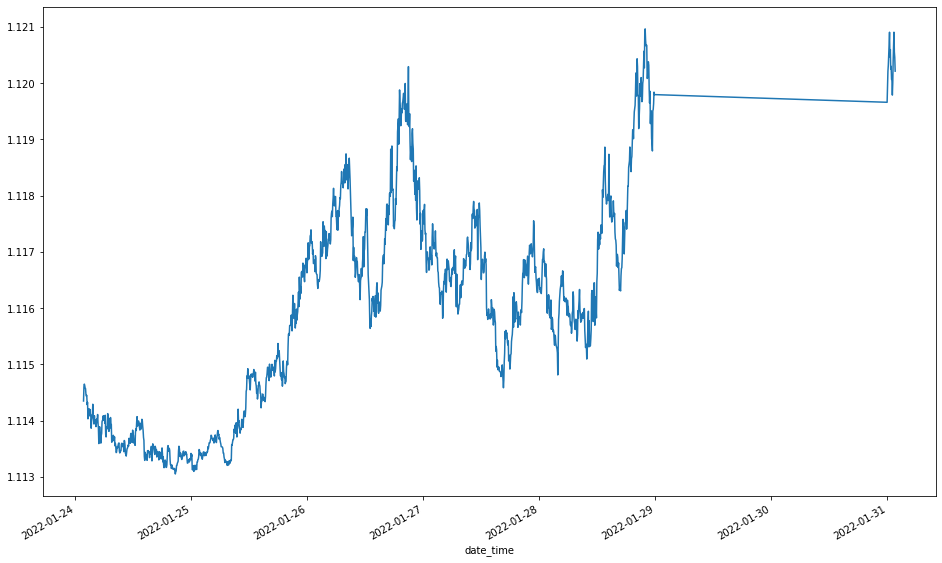

In [ ]:
#make sure to run train several times to get consensus result
#never mind the y,x axis scaling. I need to fix it. I'm looking at the shape of the forecast.
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120

ax = y_pred.plot(figsize = (16, 10)) 

In [ ]:
#contrast leaderboard result of train and test data
predictor.leaderboard(df_train, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetMXNet,-0.000304,-0.000332,0.466249,0.577092,32.181811,0.466249,0.577092,32.181811,1,True,1
1,WeightedEnsemble_L2,-0.000304,-0.000332,0.470009,0.578120,32.195224,0.003760,0.001027,0.013413,2,True,2


In [ ]:
# clears the model after a run to generate consensus analysis.
# predictor.unpersist_models('ag_predict_interval')
# predictor.save_space()
# predictor.delete_models(models_to_keep='best', dry_run=False)
%rm -rf ag_predict_interval
!ls

EURUSD_M5_201501020900_202202140140.csv  sample_data
